# Ensemble of there models achieves 0.32 LB:
- Model 1: [HMS Resnet1d GRU Inference - 1 / 5 Dataset](https://www.kaggle.com/code/konstantinboyko/hms-resnet1d-gru-inference-1-5-dataset)
- Model 2: [[Inference] Features+Head Starter [K+E+KE]](https://www.kaggle.com/code/nartaa/inference-features-head-starter-k-e-ke)
- Model 3: https://www.kaggle.com/code/naomideenen/inference

# >> Model 1 <<

In [1]:
import os
import gc
import sys
import math
import time
import random
import datetime as dt
import numpy as np
import pandas as pd

from glob import glob
from pathlib import Path
from typing import Dict, List, Union
from scipy.signal import butter, lfilter, freqz
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
from torch.utils.data import DataLoader, Dataset

#sys.path.append("/kaggle/input/kaggle-kl-div")
#from kaggle_kl_div import score

import warnings

warnings.filterwarnings("ignore")

device = torch.device("cuda")
print(device)
print(f"CuDNN Enabled:{torch.backends.cudnn.enabled}, Version:{torch.backends.cudnn.version()}")

cuda
CuDNN Enabled:True, Version:8801


## Config

In [2]:
class CFG:
    VERSION = 88

    model_name = "resnet1d_gru"

    seed = 2024
    batch_size = 1024
    num_workers = 0

    fixed_kernel_size = 5
    # kernels = [3, 5, 7, 9]
    # linear_layer_features = 424
    kernels = [3, 5, 7, 9, 11]
    #linear_layer_features = 448  # Full Signal = 10_000
    #linear_layer_features = 352  # Half Signal = 5_000
    linear_layer_features = 304   # 1/5  Signal = 2_000

    seq_length = 50  # Second's
    sampling_rate = 200  # Hz
    nsamples = seq_length * sampling_rate  # Число семплов
    out_samples = nsamples // 5

    bandpass_filter = {"low": 0.5, "high": 20, "order": 2}
    # rand_filter = {"probab": 0.1, "low": 10, "high": 20, "band": 1.0, "order": 2}
    freq_channels = []#[(8.0, 12.0)]; [(0.5, 4.5)]
    filter_order = 2
    random_close_zone = 0.0  # 0.2
        
    target_cols = [
        "seizure_vote",
        "lpd_vote",
        "gpd_vote",
        "lrda_vote",
        "grda_vote",
        "other_vote",
    ]

    # target_preds = [x + "_pred" for x in target_cols]
    # label_to_num = {"Seizure": 0, "LPD": 1, "GPD": 2, "LRDA": 3, "GRDA": 4, "Other": 5}
    # num_to_label = {v: k for k, v in label_to_num.items()}

    map_features = [
        ("Fp1", "T3"),
        ("T3", "O1"),
        ("Fp1", "C3"),
        ("C3", "O1"),
        ("Fp2", "C4"),
        ("C4", "O2"),
        ("Fp2", "T4"),
        ("T4", "O2"),
        #('Fz', 'Cz'), ('Cz', 'Pz'),
        
    ]

    eeg_features = ["Fp1", "T3", "C3", "O1", "Fp2", "C4", "T4", "O2",]  # 'Fz', 'Cz', 'Pz']
         #'F3', 'P3', 'F7', 'T5', 'Fz', 'Cz', 'Pz', 'F4', 'P4', 'F8', 'T6', 'EKG']                    
    feature_to_index = {x: y for x, y in zip(eeg_features, range(len(eeg_features)))}
    simple_features = []  # 'Fz', 'Cz', 'Pz', 'EKG'

    # eeg_features = [row for row in feature_to_index]
    # eeg_feat_size = len(eeg_features)
    
    n_map_features = len(map_features)
    in_channels = n_map_features + n_map_features * len(freq_channels) + len(simple_features)
    target_size = len(target_cols)
    
    PATH = "C:\\Users\\marcb\\OneDrive\\Desktop\\Kaggle_Competitions\\Kaggle-Competitions\\HMS-harmful-brain-activity\\"
    test_eeg = PATH+'hms-harmful-brain-activity-classification/train_eegs/'
    test_csv = PATH+'hms-harmful-brain-activity-classification/train.csv'

In [3]:
koef_1 = 1.0
model_weights = [
    {
        'bandpass_filter':{'low':0.5, 'high':20, 'order':2}, 
        'file_data': 
        [
            #{'koef':koef_1, 'file_mask':"/kaggle/input/hms-resnet1d-gru-weights-v82/pop_1_weight_oof/*_best.pth"},
            {'koef':koef_1, 'file_mask':"/kaggle/input/hms-resnet1d-gru-weights-v82/pop_2_weight_oof/*_best.pth"},
        ]
    },
]

## Utils

In [4]:
def init_logger(log_file="./test.log"):
    from logging import getLogger, INFO, FileHandler, Formatter, StreamHandler

    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return "%dm %ds" % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return "%s (remain %s)" % (asMinutes(s), asMinutes(rs))


def quantize_data(data, classes):
    mu_x = mu_law_encoding(data, classes)
    return mu_x  # quantized


def mu_law_encoding(data, mu):
    mu_x = np.sign(data) * np.log(1 + mu * np.abs(data)) / np.log(mu + 1)
    return mu_x


def mu_law_expansion(data, mu):
    s = np.sign(data) * (np.exp(np.abs(data) * np.log(mu + 1)) - 1) / mu
    return s


def butter_bandpass(lowcut, highcut, fs, order=5):
    return butter(order, [lowcut, highcut], fs=fs, btype="band")


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y


def butter_lowpass_filter(
    data, cutoff_freq=20, sampling_rate=CFG.sampling_rate, order=4
):
    nyquist = 0.5 * sampling_rate
    normal_cutoff = cutoff_freq / nyquist
    b, a = butter(order, normal_cutoff, btype="low", analog=False)
    filtered_data = lfilter(b, a, data, axis=0)
    return filtered_data


def denoise_filter(x):
    # Частота дискретизации и желаемые частоты среза (в Гц).
    # Отфильтруйте шумный сигнал
    y = butter_bandpass_filter(x, CFG.lowcut, CFG.highcut, CFG.sampling_rate, order=6)
    y = (y + np.roll(y, -1) + np.roll(y, -2) + np.roll(y, -3)) / 4
    y = y[0:-1:4]
    return y

## Parquet to EEG Signals Numpy Processing

In [5]:
def eeg_from_parquet(
    parquet_path: str, display: bool = False, seq_length=CFG.seq_length
) -> np.ndarray:
    """
    Эта функция читает файл паркета и извлекает средние 50 секунд показаний. Затем он заполняет значения NaN
    со средним значением (игнорируя NaN).
        :param parquet_path: путь к файлу паркета.
        :param display: отображать графики ЭЭГ или нет.
        :return data: np.array формы (time_steps, eeg_features) -> (10_000, 8)
    """

    # Вырезаем среднюю 50 секундную часть
    eeg = pd.read_parquet(parquet_path, columns=CFG.eeg_features)
    rows = len(eeg)

    # начало смещения данных, чтобы забрать середину
    offset = (rows - CFG.nsamples) // 2

    # средние 50 секунд, имеет одинаковое количество показаний слева и справа
    eeg = eeg.iloc[offset : offset + CFG.nsamples]

    if display:
        plt.figure(figsize=(10, 5))
        offset = 0

    # Конвертировать в numpy

    # создать заполнитель той же формы с нулями
    data = np.zeros((CFG.nsamples, len(CFG.eeg_features)))

    for index, feature in enumerate(CFG.eeg_features):
        x = eeg[feature].values.astype("float32")  # конвертировать в float32

        # Вычисляет среднее арифметическое вдоль указанной оси, игнорируя NaN.
        mean = np.nanmean(x)
        nan_percentage = np.isnan(x).mean()  # percentage of NaN values in feature

        # Заполнение значения Nan
        # Поэлементная проверка на NaN и возврат результата в виде логического массива.
        if nan_percentage < 1:  # если некоторые значения равны Nan, но не все
            x = np.nan_to_num(x, nan=mean)
        else:  # если все значения — Nan
            x[:] = 0
        data[:, index] = x

        if display:
            if index != 0:
                offset += x.max()
            plt.plot(range(CFG.nsamples), x - offset, label=feature)
            offset -= x.min()

    if display:
        plt.legend()
        name = parquet_path.split("/")[-1].split(".")[0]
        plt.yticks([])
        plt.title(f"EEG {name}", size=16)
        plt.show()
    return data

In [6]:
CFG.freq_channels

[]

In [7]:
class EEGDataset(Dataset):
    def __init__(
        self,
        df: pd.DataFrame,
        batch_size: int,
        eegs: Dict[int, np.ndarray],
        mode: str = "train",
        downsample: int = None,
        bandpass_filter: Dict[str, Union[int, float]] = None,
        rand_filter: Dict[str, Union[int, float]] = None,
    ):
        self.df = df
        self.batch_size = batch_size
        self.mode = mode
        self.eegs = eegs
        self.downsample = downsample
        self.bandpass_filter = bandpass_filter
        self.rand_filter = rand_filter
        
    def __len__(self):
        """
        Length of dataset.
        """
        # Обозначает количество пакетов за эпоху
        return len(self.df)

    def __getitem__(self, index):
        """
        Get one item.
        """
        # Сгенерировать один пакет данных
        X, y_prob = self.__data_generation(index)
        if self.downsample is not None:
            X = X[:: self.downsample, :]
        output = {
            "eeg": torch.tensor(X, dtype=torch.float32),
            "labels": torch.tensor(y_prob, dtype=torch.float32),
        }
        return output

    def __data_generation(self, index):
        # Генерирует данные, содержащие образцы размера партии
        X = np.zeros(
            (CFG.out_samples, CFG.in_channels), dtype="float32"
        )  # Size=(10000, 14)

        row = self.df.iloc[index]  # Строка Pandas
        data = self.eegs[row.eeg_id]  # Size=(10000, 8)
        if CFG.nsamples != CFG.out_samples:
            if self.mode != "train":
                offset = (CFG.nsamples - CFG.out_samples) // 2
            else:
                #offset = random.randint(0, CFG.nsamples - CFG.out_samples)                
                offset = ((CFG.nsamples - CFG.out_samples) * random.randint(0, 1000)) // 1000
            data = data[offset:offset+CFG.out_samples,:]

        for i, (feat_a, feat_b) in enumerate(CFG.map_features):
            if self.mode == "train" and CFG.random_close_zone > 0 and random.uniform(0.0, 1.0) <= CFG.random_close_zone:
                continue
                
            diff_feat = (
                data[:, CFG.feature_to_index[feat_a]]
                - data[:, CFG.feature_to_index[feat_b]]
            )  # Size=(10000,)

            if not self.bandpass_filter is None:
                diff_feat = butter_bandpass_filter(
                    diff_feat,
                    self.bandpass_filter["low"],
                    self.bandpass_filter["high"],
                    CFG.sampling_rate,
                    order=self.bandpass_filter["order"],
                )
                    
            if (
                self.mode == "train"
                and not self.rand_filter is None
                and random.uniform(0.0, 1.0) <= self.rand_filter["probab"]
            ):
                lowcut = random.randint(
                    self.rand_filter["low"], self.rand_filter["high"]
                )
                highcut = lowcut + self.rand_filter["band"]
                diff_feat = butter_bandpass_filter(
                    diff_feat,
                    lowcut,
                    highcut,
                    CFG.sampling_rate,
                    order=self.rand_filter["order"],
                )

            X[:, i] = diff_feat

        n = CFG.n_map_features
        if len(CFG.freq_channels) > 0:
            for i in range(CFG.n_map_features):
                diff_feat = X[:, i]
                for j, (lowcut, highcut) in enumerate(CFG.freq_channels):
                    band_feat = butter_bandpass_filter(
                        diff_feat, lowcut, highcut, CFG.sampling_rate, order=CFG.filter_order,  # 6
                    )
                    X[:, n] = band_feat
                    n += 1

        for spml_feat in CFG.simple_features:
            feat_val = data[:, CFG.feature_to_index[spml_feat]]
            
            if not self.bandpass_filter is None:
                feat_val = butter_bandpass_filter(
                    feat_val,
                    self.bandpass_filter["low"],
                    self.bandpass_filter["high"],
                    CFG.sampling_rate,
                    order=self.bandpass_filter["order"],
                )

            if (
                self.mode == "train"
                and not self.rand_filter is None
                and random.uniform(0.0, 1.0) <= self.rand_filter["probab"]
            ):
                lowcut = random.randint(
                    self.rand_filter["low"], self.rand_filter["high"]
                )
                highcut = lowcut + self.rand_filter["band"]
                feat_val = butter_bandpass_filter(
                    feat_val,
                    lowcut,
                    highcut,
                    CFG.sampling_rate,
                    order=self.rand_filter["order"],
                )

            X[:, n] = feat_val
            n += 1
            
        # Обрезать края превышающие значения [-1024, 1024]
        X = np.clip(X, -1024, 1024)

        # Замените NaN нулем и разделить все на 32
        X = np.nan_to_num(X, nan=0) / 32.0

        # обрезать полосовым фильтром верхнюю границу в 20 Hz.
        X = butter_lowpass_filter(X, order=CFG.filter_order)  # 4
       # print(X.shape)
        # for i in range(X.shape[1]):
        #     X[:,i] = (X[:,i] - np.min(X[:,i]))/(np.max(X[:,i])-np.min(X[:,i]))
        

        y_prob = np.zeros(CFG.target_size, dtype="float32")  # Size=(6,)
        if self.mode != "test":
            y_prob = row[CFG.target_cols].values.astype(np.float32)

        return X, y_prob

## Model

In [8]:
class ResNet_1D_Block(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        kernel_size,
        stride,
        padding,
        downsampling,
        dilation=1,
        groups=1,
        dropout=0.0,
    ):
        super(ResNet_1D_Block, self).__init__()

        self.bn1 = nn.BatchNorm1d(num_features=in_channels)
        # self.relu = nn.ReLU(inplace=False)
        # self.relu_1 = nn.PReLU()
        # self.relu_2 = nn.PReLU()
        self.relu_1 = nn.Hardswish()
        self.relu_2 = nn.Hardswish()

        self.dropout = nn.Dropout(p=dropout, inplace=False)
        self.conv1 = nn.Conv1d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            dilation=dilation,
            groups=groups,
            bias=False,
        )

        self.bn2 = nn.BatchNorm1d(num_features=out_channels)
        self.conv2 = nn.Conv1d(
            in_channels=out_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            dilation=dilation,
            groups=groups,
            bias=False,
        )

        self.maxpool = nn.MaxPool1d(
            kernel_size=2,
            stride=2,
            padding=0,
            dilation=dilation,
        )
        self.downsampling = downsampling

    def forward(self, x):
        identity = x

        out = self.bn1(x)
        out = self.relu_1(out)
        out = self.dropout(out)
        out = self.conv1(out)
        out = self.bn2(out)
        out = self.relu_2(out)
        out = self.dropout(out)
        out = self.conv2(out)

        out = self.maxpool(out)
        identity = self.downsampling(x)

        out += identity
        return out


class EEGNet(nn.Module):
    def __init__(
        self,
        kernels,
        in_channels,
        fixed_kernel_size,
        num_classes,
        linear_layer_features,
        dilation=1,
        groups=1,
    ):
        super(EEGNet, self).__init__()
        self.kernels = kernels
        self.planes = 24
        self.parallel_conv = nn.ModuleList()
        self.in_channels = in_channels

        for i, kernel_size in enumerate(list(self.kernels)):
            sep_conv = nn.Conv1d(
                in_channels=in_channels,
                out_channels=self.planes,
                kernel_size=(kernel_size),
                stride=1,
                padding=0,
                dilation=dilation,
                groups=groups,
                bias=False,
            )
            self.parallel_conv.append(sep_conv)

        self.bn1 = nn.BatchNorm1d(num_features=self.planes)
        # self.relu = nn.ReLU(inplace=False)
        # self.relu_1 = nn.ReLU()
        # self.relu_2 = nn.ReLU()
        self.relu_1 = nn.SiLU()
        self.relu_2 = nn.SiLU()

        self.conv1 = nn.Conv1d(
            in_channels=self.planes,
            out_channels=self.planes,
            kernel_size=fixed_kernel_size,
            stride=2,
            padding=2,
            dilation=dilation,
            groups=groups,
            bias=False,
        )

        self.block = self._make_resnet_layer(
            kernel_size=fixed_kernel_size,
            stride=1,
            dilation=dilation,
            groups=groups,
            padding=fixed_kernel_size // 2,
        )
        self.bn2 = nn.BatchNorm1d(num_features=self.planes)
        self.avgpool = nn.AvgPool1d(kernel_size=6, stride=6, padding=2)

        self.rnn = nn.GRU(
            input_size=self.in_channels,
            hidden_size=128,
            num_layers=1,
            bidirectional=True,
            # dropout=0.2,
        )

        self.fc = nn.Linear(in_features=linear_layer_features, out_features=num_classes)

    def _make_resnet_layer(
        self,
        kernel_size,
        stride,
        dilation=1,
        groups=1,
        blocks=9,
        padding=0,
        dropout=0.0,
    ):
        layers = []
        downsample = None
        base_width = self.planes

        for i in range(blocks):
            downsampling = nn.Sequential(
                nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
            )
            layers.append(
                ResNet_1D_Block(
                    in_channels=self.planes,
                    out_channels=self.planes,
                    kernel_size=kernel_size,
                    stride=stride,
                    padding=padding,
                    downsampling=downsampling,
                    dilation=dilation,
                    groups=groups,
                    dropout=dropout,
                )
            )
        return nn.Sequential(*layers)

    def extract_features(self, x):
        x = x.permute(0, 2, 1)
        out_sep = []

        for i in range(len(self.kernels)):
            sep = self.parallel_conv[i](x)
            out_sep.append(sep)

        out = torch.cat(out_sep, dim=2)
        out = self.bn1(out)
        out = self.relu_1(out)
        out = self.conv1(out)

        out = self.block(out)
        out = self.bn2(out)
        out = self.relu_2(out)
        out = self.avgpool(out)

        out = out.reshape(out.shape[0], -1)
        rnn_out, _ = self.rnn(x.permute(0, 2, 1))
        new_rnn_h = rnn_out[:, -1, :]  # <~~

        new_out = torch.cat([out, new_rnn_h], dim=1)
        return new_out

    def forward(self, x):
        new_out = self.extract_features(x)
        result = self.fc(new_out)
        return result

## Inference Function

In [9]:
def inference_function(test_loader, model, device):
    model.eval()  # set model in evaluation mode
    softmax = nn.Softmax(dim=1)
    prediction_dict = {}
    preds = []
    with tqdm(test_loader, unit="test_batch", desc="Inference") as tqdm_test_loader:
        for step, batch in enumerate(tqdm_test_loader):
            X = batch.pop("eeg").to(device)  # send inputs to `device`
            batch_size = X.size(0)
            with torch.no_grad():
                y_preds = model(X)  # forward propagation pass
            y_preds = softmax(y_preds)
            preds.append(y_preds.to("cpu").numpy())  # save predictions

    prediction_dict["predictions"] = np.concatenate(
        preds
    )  # np.array() of shape (fold_size, target_cols)
    return prediction_dict

## Load data

In [10]:
test_df = pd.read_csv(CFG.test_csv)
print(f"Test dataframe shape is: {test_df.shape}")
test_df.head()

Test dataframe shape is: (106800, 15)


,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0


In [11]:
test_eeg_parquet_paths = glob(CFG.test_eeg + "*.parquet")
test_eeg_df = pd.read_parquet(test_eeg_parquet_paths[0])
test_eeg_features = test_eeg_df.columns
print(f"There are {len(test_eeg_features)} raw eeg features")
print(list(test_eeg_features))
del test_eeg_df
_ = gc.collect()

# %%time
import joblib
from joblib import Parallel, delayed
from tqdm import tqdm

def process_eeg(eeg_id):
    eeg_path = CFG.test_eeg + str(eeg_id) + ".parquet"
    data = eeg_from_parquet(eeg_path)
    return eeg_id, data

all_eegs = {}
eeg_ids = test_df.eeg_id.unique()

results = Parallel(n_jobs=-1)(delayed(process_eeg)(eeg_id) for eeg_id in tqdm(eeg_ids))

all_eegs = dict(results)

There are 20 raw eeg features
['Fp1', 'F3', 'C3', 'P3', 'F7', 'T3', 'T5', 'O1', 'Fz', 'Cz', 'Pz', 'Fp2', 'F4', 'C4', 'P4', 'F8', 'T4', 'T6', 'O2', 'EKG']


100%|██████████| 17089/17089 [00:24<00:00, 703.01it/s]


In [12]:
results

[(1628180742,
  array([[-116.83999634, -113.55999756, -128.30999756, ..., -135.19999695,
           -96.16999817, -102.23000336],
         [-118.19999695, -127.18000031, -132.8500061 , ..., -125.41000366,
           -94.05000305, -104.19999695],
         [-118.26999664, -119.19000244, -128.41000366, ..., -126.69000244,
           -98.69999695, -107.69999695],
         ...,
         [-139.72000122, -183.6000061 , -112.37999725, ...,  -84.54000092,
          -107.58999634, -106.12000275],
         [-137.86999512, -179.80999756, -111.08999634, ..., -104.26999664,
          -103.06999969, -101.30999756],
         [-128.52000427, -165.33999634, -121.09999847, ..., -119.23999786,
          -109.18000031, -106.51999664]])),
 (2277392603,
  array([[ 11.06999969,  13.13000011,  11.35000038, ...,   1.40999997,
           -8.85000038, -38.13000107],
         [ 15.27999973,  12.27999973,  13.15999985, ...,   1.80999994,
          -10.44999981, -35.61999893],
         [ 18.20999908,   9.60000038,  

(100, 8)

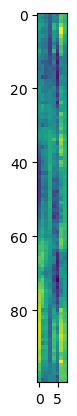

In [13]:
import matplotlib.pyplot as plt
plt.imshow(all_eegs[1628180742][0:100])
all_eegs[1628180742][0:100].shape

In [42]:
data_pqt = pd.read_parquet(CFG.test_eeg+'568657.parquet')

In [49]:
all_eegs[1628180742].shape
data_pqt

,Fp1,F3,C3,P3,F7,T3,T5,O1,Fz,Cz,Pz,Fp2,F4,C4,P4,F8,T4,T6,O2,EKG
0,-75.360001,86.379997,65.470001,62.580002,170.350006,92.370003,39.680000,89.870003,18.260000,-28.440001,-15.190000,16.930000,13.810000,-42.160000,78.099998,-143.649994,121.239998,-1.470000,72.550003,-3090.090088
1,-107.739998,53.139999,32.590000,21.950001,140.500000,59.070000,4.260000,53.310001,-18.490000,-63.270000,-52.110001,-13.230000,-16.420000,-80.430000,64.449997,-168.500000,88.400002,-28.520000,40.250000,5560.439941
2,-103.050003,46.330002,10.750000,9.150000,137.820007,50.950001,-3.500000,45.070000,-20.879999,-66.629997,-69.750000,-9.200000,-21.400000,-93.089996,5.120000,-176.089996,51.689999,-38.639999,31.820000,-4161.450195
3,-75.099998,77.870003,40.150002,31.790001,166.630005,76.769997,17.990000,67.650002,11.140000,-32.950001,-38.509998,14.770000,9.790000,-66.480003,48.220001,-147.990005,86.629997,-18.639999,62.509998,31769.970703
4,-97.919998,58.209999,27.330000,5.340000,144.080002,47.200001,-10.430000,40.250000,-12.350000,-52.500000,-54.919998,-10.070000,-8.040000,-90.820000,67.269997,-164.710007,80.680000,-36.520000,41.830002,6879.720215
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13195,-160.800003,-114.349998,-129.779999,-59.860001,-166.770004,-55.310001,-61.900002,-66.510002,-40.220001,-44.689999,-126.870003,-119.510002,-89.480003,-176.240005,1.300000,-161.649994,-6.820000,102.620003,-46.330002,2097.229980
13196,-169.919998,-132.699997,-154.160004,-69.129997,-184.130005,-77.470001,-75.959999,-75.910004,-54.389999,-57.410000,-140.020004,-127.639999,-107.169998,-191.160004,-60.020000,-181.389999,-40.779999,92.239998,-59.740002,1954.630005
13197,-141.600006,-99.709999,-120.599998,-28.770000,-154.869995,-47.549999,-41.610001,-36.299999,-22.420000,-16.940001,-94.050003,-100.709999,-75.910004,-145.940002,-26.469999,-152.240005,2.190000,120.709999,-19.320000,-3010.149902
13198,-155.550003,-105.559998,-116.540001,-31.240000,-163.490005,-60.480000,-51.320000,-43.490002,-34.860001,-22.889999,-84.669998,-116.760002,-77.989998,-138.279999,23.129999,-149.500000,28.150000,118.300003,-21.100000,280.119995


In [37]:
eeg_path='C:\\Users\\marcb\\OneDrive\\Desktop\\Kaggle_Competitions\\Kaggle-Competitions\\HMS-harmful-brain-activity\\brain-eeg-spectograms\\EEG_Spectrograms/'

In [39]:
data = np.load(eeg_path+'568657.npy')
data.shape

(128, 256, 4)

In [12]:
model_block=model_weights[0]
test_dataset = EEGDataset(
        df=test_df,
        batch_size=CFG.batch_size,
        mode="train",
        eegs=all_eegs,
        bandpass_filter=model_block['bandpass_filter']
    )

         
test_loader = DataLoader(
        test_dataset,
        batch_size=CFG.batch_size,
        shuffle=True,
        num_workers=0,
        drop_last=False,
    )

x = next(iter(test_loader))

{'eeg': tensor([[[-1.8477e-03,  1.8110e-03,  3.6246e-04,  ..., -3.5865e-03,
            1.6665e-03,  3.5429e-05],
          [-1.4051e-02,  1.2913e-02,  2.0619e-03,  ..., -2.5893e-02,
            1.1461e-02,  6.9297e-04],
          [-5.2372e-02,  4.3393e-02,  3.6874e-03,  ..., -8.9512e-02,
            3.6502e-02,  4.4732e-03],
          ...,
          [-1.3336e-01,  7.9665e-02, -3.5076e-01,  ..., -8.0139e-02,
            5.9401e-03, -3.1555e-01],
          [-1.2468e-01,  5.8201e-02, -3.5997e-01,  ..., -5.8770e-02,
            1.7300e-02, -2.8749e-01],
          [-1.0593e-01,  2.2114e-02, -3.5134e-01,  ..., -2.6104e-02,
            2.8138e-02, -2.4569e-01]],
 
         [[ 2.0562e-03, -1.5330e-03, -2.9038e-03,  ...,  1.8368e-03,
            3.4925e-03, -3.0687e-03],
          [ 1.6112e-02, -1.0900e-02, -2.0762e-02,  ...,  1.4311e-02,
            2.3612e-02, -2.0949e-02],
          [ 6.0986e-02, -3.7322e-02, -7.1147e-02,  ...,  4.9963e-02,
            7.6455e-02, -6.8540e-02],
          ..

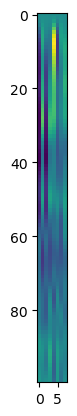

In [24]:
plt.imshow(x['eeg'][0,0:100,:])
x

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()


        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(16000, 30000)
        #self.relu4 = nn.ReLU()
        #self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(30000, 6)

    def forward(self, x):


        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        #x = self.relu4(x)
        #x = self.dropout(x)
        x = self.fc2(x)

        return F.softmax(x)

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR

model = MyModel()

# Assuming you have already defined your model, test_loader, and other necessary components

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define loss function
criterion = nn.KLDivLoss(reduction='batchmean')

# Define optimizer
optimizer = optim.AdamW(model.parameters(),lr=4e-3 )

# Define learning rate scheduler
#scheduler = CosineAnnealingLR(optimizer, T_max=10)

# Training loop
num_epochs = 10
model.train()
for epoch in range(num_epochs):
    
    running_loss = 0.0
    
    for batch in tqdm(test_loader):
        eeg = batch['eeg'].to(device)
        labels = batch['labels'].to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(eeg)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        print(loss.item())
    
    # Update learning rate
    #scheduler.step()
    
    # Print epoch statistics
    epoch_loss = running_loss / len(test_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

print("Training finished!")

  1%|          | 1/105 [00:02<04:56,  2.85s/it]

11.056724548339844


  2%|▏         | 2/105 [00:05<04:46,  2.78s/it]

10.009416580200195


  3%|▎         | 3/105 [00:08<04:40,  2.75s/it]

10.440396308898926


  4%|▍         | 4/105 [00:11<04:35,  2.73s/it]

10.39219856262207


  5%|▍         | 5/105 [00:13<04:32,  2.72s/it]

10.959211349487305


  6%|▌         | 6/105 [00:16<04:28,  2.72s/it]

10.256053924560547


  7%|▋         | 7/105 [00:19<04:26,  2.72s/it]

10.4972505569458


  8%|▊         | 8/105 [00:21<04:23,  2.72s/it]

10.990979194641113


  9%|▊         | 9/105 [00:24<04:21,  2.72s/it]

10.25520133972168


 10%|▉         | 10/105 [00:27<04:18,  2.72s/it]

10.403963088989258


 10%|█         | 11/105 [00:30<04:15,  2.72s/it]

10.592767715454102


 11%|█▏        | 12/105 [00:32<04:12,  2.72s/it]

10.407596588134766


 12%|█▏        | 13/105 [00:35<04:09,  2.71s/it]

10.50277042388916


 13%|█▎        | 14/105 [00:38<04:06,  2.71s/it]

10.129302978515625


 14%|█▍        | 15/105 [00:40<04:04,  2.72s/it]

10.149234771728516


 15%|█▌        | 16/105 [00:43<04:01,  2.71s/it]

9.795042037963867


 16%|█▌        | 17/105 [00:46<03:58,  2.71s/it]

9.950231552124023


 17%|█▋        | 18/105 [00:48<03:55,  2.71s/it]

10.805319786071777


 18%|█▊        | 19/105 [00:51<03:53,  2.71s/it]

9.816679000854492


 19%|█▉        | 20/105 [00:54<03:55,  2.77s/it]

10.47459602355957


 20%|██        | 21/105 [00:57<03:51,  2.75s/it]

9.45425033569336


 21%|██        | 22/105 [01:00<03:47,  2.74s/it]

10.378015518188477


 22%|██▏       | 23/105 [01:02<03:44,  2.73s/it]

10.570388793945312


 23%|██▎       | 24/105 [01:05<03:41,  2.73s/it]

9.567419052124023


 24%|██▍       | 25/105 [01:08<03:37,  2.72s/it]

11.004249572753906


 25%|██▍       | 26/105 [01:10<03:34,  2.72s/it]

10.057517051696777


 26%|██▌       | 27/105 [01:13<03:32,  2.72s/it]

9.956235885620117


 27%|██▋       | 28/105 [01:16<03:29,  2.72s/it]

10.243305206298828


 28%|██▊       | 29/105 [01:19<03:26,  2.72s/it]

10.629121780395508


 29%|██▊       | 30/105 [01:21<03:24,  2.72s/it]

10.091665267944336


 30%|██▉       | 31/105 [01:24<03:21,  2.73s/it]

10.55392074584961


 30%|███       | 32/105 [01:27<03:18,  2.72s/it]

10.493452072143555


 31%|███▏      | 33/105 [01:29<03:15,  2.72s/it]

11.12751293182373


 32%|███▏      | 34/105 [01:32<03:12,  2.72s/it]

10.177665710449219


 33%|███▎      | 35/105 [01:35<03:10,  2.72s/it]

10.49153995513916


 34%|███▍      | 36/105 [01:38<03:07,  2.71s/it]

10.13973617553711


 35%|███▌      | 37/105 [01:40<03:04,  2.71s/it]

10.358955383300781


 36%|███▌      | 38/105 [01:43<03:01,  2.71s/it]

10.764139175415039


 37%|███▋      | 39/105 [01:46<02:58,  2.71s/it]

10.089186668395996


 38%|███▊      | 40/105 [01:48<02:56,  2.71s/it]

10.667646408081055


 39%|███▉      | 41/105 [01:51<02:53,  2.71s/it]

10.5452880859375


 40%|████      | 42/105 [01:54<02:50,  2.71s/it]

10.472602844238281


 41%|████      | 43/105 [01:57<02:48,  2.72s/it]

10.61179256439209


 42%|████▏     | 44/105 [01:59<02:45,  2.72s/it]

9.886329650878906


 43%|████▎     | 45/105 [02:02<02:42,  2.71s/it]

10.859062194824219


 44%|████▍     | 46/105 [02:05<02:40,  2.71s/it]

10.817678451538086


 45%|████▍     | 47/105 [02:07<02:37,  2.72s/it]

10.75407600402832


 46%|████▌     | 48/105 [02:10<02:34,  2.72s/it]

10.741546630859375


 47%|████▋     | 49/105 [02:13<02:32,  2.72s/it]

10.085811614990234


 48%|████▊     | 50/105 [02:16<02:29,  2.72s/it]

9.823111534118652


 49%|████▊     | 51/105 [02:18<02:26,  2.72s/it]

10.670881271362305


 50%|████▉     | 52/105 [02:21<02:24,  2.72s/it]

10.045741081237793


 50%|█████     | 53/105 [02:24<02:21,  2.72s/it]

10.4937744140625


 51%|█████▏    | 54/105 [02:26<02:18,  2.72s/it]

10.6945161819458


 52%|█████▏    | 55/105 [02:29<02:16,  2.72s/it]

10.681207656860352


 53%|█████▎    | 56/105 [02:32<02:13,  2.72s/it]

10.168079376220703


 54%|█████▍    | 57/105 [02:35<02:10,  2.71s/it]

9.769808769226074


 55%|█████▌    | 58/105 [02:37<02:07,  2.71s/it]

10.433541297912598


 56%|█████▌    | 59/105 [02:40<02:05,  2.72s/it]

10.161308288574219


 57%|█████▋    | 60/105 [02:43<02:02,  2.72s/it]

10.202920913696289


 58%|█████▊    | 61/105 [02:46<01:59,  2.72s/it]

10.69182014465332


 59%|█████▉    | 62/105 [02:48<01:57,  2.73s/it]

10.540552139282227


 60%|██████    | 63/105 [02:51<01:54,  2.73s/it]

10.494462966918945


 61%|██████    | 64/105 [02:54<01:51,  2.72s/it]

10.56321907043457


 62%|██████▏   | 65/105 [02:56<01:49,  2.73s/it]

10.671894073486328


 63%|██████▎   | 66/105 [02:59<01:46,  2.72s/it]

10.585348129272461


 64%|██████▍   | 67/105 [03:02<01:43,  2.72s/it]

10.124885559082031


 65%|██████▍   | 68/105 [03:05<01:40,  2.72s/it]

10.25899887084961


 66%|██████▌   | 69/105 [03:07<01:37,  2.72s/it]

9.685577392578125


 67%|██████▋   | 70/105 [03:10<01:35,  2.72s/it]

10.226274490356445


 68%|██████▊   | 71/105 [03:13<01:32,  2.72s/it]

11.02041244506836


 69%|██████▊   | 72/105 [03:15<01:29,  2.72s/it]

10.070977210998535


 70%|██████▉   | 73/105 [03:18<01:27,  2.73s/it]

10.543549537658691


 70%|███████   | 74/105 [03:21<01:24,  2.73s/it]

10.076736450195312


 71%|███████▏  | 75/105 [03:24<01:21,  2.73s/it]

10.06263256072998


 72%|███████▏  | 76/105 [03:26<01:19,  2.73s/it]

10.298503875732422


 73%|███████▎  | 77/105 [03:29<01:16,  2.73s/it]

10.088584899902344


 74%|███████▍  | 78/105 [03:32<01:13,  2.73s/it]

10.730972290039062


 75%|███████▌  | 79/105 [03:35<01:10,  2.72s/it]

10.248950958251953


 76%|███████▌  | 80/105 [03:37<01:08,  2.72s/it]

10.55216121673584


 77%|███████▋  | 81/105 [03:40<01:05,  2.72s/it]

9.941084861755371


 78%|███████▊  | 82/105 [03:43<01:02,  2.72s/it]

10.40826416015625


 79%|███████▉  | 83/105 [03:45<00:59,  2.72s/it]

10.45106029510498


 80%|████████  | 84/105 [03:48<00:57,  2.72s/it]

10.449785232543945


 81%|████████  | 85/105 [03:51<00:54,  2.73s/it]

10.449850082397461


 82%|████████▏ | 86/105 [03:54<00:51,  2.72s/it]

10.421125411987305


 83%|████████▎ | 87/105 [03:56<00:49,  2.73s/it]

10.80019760131836


 84%|████████▍ | 88/105 [03:59<00:46,  2.73s/it]

9.720285415649414


 85%|████████▍ | 89/105 [04:02<00:43,  2.73s/it]

10.886909484863281


 86%|████████▌ | 90/105 [04:04<00:40,  2.72s/it]

10.701909065246582


 87%|████████▋ | 91/105 [04:07<00:38,  2.72s/it]

10.792367935180664


 88%|████████▊ | 92/105 [04:10<00:35,  2.72s/it]

10.003965377807617


 89%|████████▊ | 93/105 [04:13<00:32,  2.72s/it]

10.780519485473633


 90%|████████▉ | 94/105 [04:15<00:29,  2.72s/it]

10.473114013671875


 90%|█████████ | 95/105 [04:18<00:27,  2.72s/it]

10.728042602539062


 91%|█████████▏| 96/105 [04:21<00:24,  2.71s/it]

9.897245407104492


 92%|█████████▏| 97/105 [04:23<00:21,  2.71s/it]

10.408811569213867


 93%|█████████▎| 98/105 [04:26<00:19,  2.72s/it]

10.564369201660156


 94%|█████████▍| 99/105 [04:29<00:16,  2.72s/it]

10.362638473510742


 95%|█████████▌| 100/105 [04:32<00:13,  2.72s/it]

10.755127906799316


 96%|█████████▌| 101/105 [04:34<00:10,  2.72s/it]

10.126875877380371


 97%|█████████▋| 102/105 [04:37<00:08,  2.72s/it]

9.479890823364258


 98%|█████████▊| 103/105 [04:40<00:05,  2.72s/it]

10.303245544433594


 99%|█████████▉| 104/105 [04:43<00:02,  2.72s/it]

10.57358169555664


100%|██████████| 105/105 [04:43<00:00,  2.70s/it]


9.622027397155762
Epoch [1/10], Loss: 10.3739


  1%|          | 1/105 [00:02<04:44,  2.74s/it]

11.18471622467041


  2%|▏         | 2/105 [00:05<04:41,  2.73s/it]

10.179046630859375


  3%|▎         | 3/105 [00:08<04:38,  2.73s/it]

9.819814682006836


  4%|▍         | 4/105 [00:10<04:35,  2.73s/it]

10.325469970703125


  5%|▍         | 5/105 [00:13<04:32,  2.72s/it]

10.060930252075195


  6%|▌         | 6/105 [00:16<04:29,  2.72s/it]

10.276456832885742


  7%|▋         | 7/105 [00:19<04:26,  2.72s/it]

10.338996887207031


  8%|▊         | 8/105 [00:21<04:23,  2.72s/it]

9.669713973999023


  9%|▊         | 9/105 [00:24<04:20,  2.72s/it]

10.538125038146973


 10%|▉         | 10/105 [00:27<04:17,  2.72s/it]

10.056002616882324


 10%|█         | 11/105 [00:29<04:15,  2.71s/it]

10.52295970916748


 11%|█▏        | 12/105 [00:32<04:13,  2.72s/it]

11.054885864257812


 12%|█▏        | 13/105 [00:35<04:10,  2.72s/it]

10.25895881652832


 13%|█▎        | 14/105 [00:38<04:07,  2.72s/it]

10.519447326660156


 14%|█▍        | 15/105 [00:40<04:04,  2.72s/it]

10.31448745727539


 15%|█▌        | 16/105 [00:43<04:01,  2.72s/it]

9.595279693603516


 16%|█▌        | 17/105 [00:46<03:59,  2.72s/it]

10.962791442871094


 17%|█▋        | 18/105 [00:48<03:56,  2.72s/it]

10.37889575958252


 18%|█▊        | 19/105 [00:51<03:53,  2.72s/it]

10.60684871673584


 19%|█▉        | 20/105 [00:54<03:50,  2.71s/it]

10.308713912963867


 20%|██        | 21/105 [00:57<03:47,  2.71s/it]

10.66154670715332


 21%|██        | 22/105 [00:59<03:45,  2.71s/it]

9.877791404724121


 22%|██▏       | 23/105 [01:02<03:42,  2.71s/it]

10.455924987792969


 23%|██▎       | 24/105 [01:05<03:39,  2.71s/it]

10.466547012329102


 24%|██▍       | 25/105 [01:07<03:37,  2.72s/it]

10.226249694824219


 25%|██▍       | 26/105 [01:10<03:34,  2.72s/it]

10.340646743774414


 26%|██▌       | 27/105 [01:13<03:31,  2.72s/it]

10.115286827087402


 27%|██▋       | 28/105 [01:16<03:29,  2.72s/it]

10.142695426940918


 28%|██▊       | 29/105 [01:18<03:26,  2.72s/it]

10.405471801757812


 29%|██▊       | 30/105 [01:21<03:23,  2.72s/it]

9.871801376342773


 30%|██▉       | 31/105 [01:24<03:20,  2.71s/it]

10.252877235412598


 30%|███       | 32/105 [01:26<03:18,  2.71s/it]

10.176010131835938


 31%|███▏      | 33/105 [01:29<03:15,  2.72s/it]

9.922964096069336


 32%|███▏      | 34/105 [01:32<03:13,  2.72s/it]

11.057796478271484


 33%|███▎      | 35/105 [01:35<03:10,  2.72s/it]

10.8049898147583


 34%|███▍      | 36/105 [01:37<03:07,  2.72s/it]

10.962896347045898


 35%|███▌      | 37/105 [01:40<03:04,  2.71s/it]

10.387454986572266


 36%|███▌      | 38/105 [01:43<03:01,  2.71s/it]

10.61237907409668


 37%|███▋      | 39/105 [01:45<02:58,  2.71s/it]

10.74287223815918


 38%|███▊      | 40/105 [01:48<02:56,  2.71s/it]

9.86245059967041


 39%|███▉      | 41/105 [01:51<02:53,  2.71s/it]

10.338912963867188


 40%|████      | 42/105 [01:54<02:50,  2.71s/it]

10.863117218017578


 41%|████      | 43/105 [01:56<02:48,  2.72s/it]

9.952335357666016


 42%|████▏     | 44/105 [01:59<02:45,  2.72s/it]

10.681525230407715


 43%|████▎     | 45/105 [02:02<02:43,  2.72s/it]

9.947782516479492


 44%|████▍     | 46/105 [02:05<02:40,  2.72s/it]

10.127224922180176


 45%|████▍     | 47/105 [02:07<02:38,  2.73s/it]

10.477235794067383


 46%|████▌     | 48/105 [02:10<02:35,  2.72s/it]

10.67205810546875


 47%|████▋     | 49/105 [02:13<02:32,  2.72s/it]

10.769508361816406


 48%|████▊     | 50/105 [02:15<02:29,  2.72s/it]

9.943245887756348


 49%|████▊     | 51/105 [02:18<02:27,  2.73s/it]

10.637348175048828


 50%|████▉     | 52/105 [02:21<02:24,  2.72s/it]

10.266647338867188


 50%|█████     | 53/105 [02:24<02:21,  2.72s/it]

10.384634017944336


 51%|█████▏    | 54/105 [02:26<02:18,  2.72s/it]

10.150876998901367


 52%|█████▏    | 55/105 [02:29<02:15,  2.72s/it]

9.82692813873291


 53%|█████▎    | 56/105 [02:32<02:13,  2.72s/it]

10.454316139221191


 54%|█████▍    | 57/105 [02:34<02:10,  2.72s/it]

9.994837760925293


 55%|█████▌    | 58/105 [02:37<02:07,  2.72s/it]

10.680986404418945


 56%|█████▌    | 59/105 [02:40<02:05,  2.72s/it]

10.064480781555176


 57%|█████▋    | 60/105 [02:43<02:02,  2.72s/it]

10.183836936950684


 58%|█████▊    | 61/105 [02:45<01:59,  2.72s/it]

10.329574584960938


 59%|█████▉    | 62/105 [02:48<01:56,  2.72s/it]

9.944628715515137


 60%|██████    | 63/105 [02:51<01:54,  2.72s/it]

10.495849609375


 61%|██████    | 64/105 [02:53<01:51,  2.72s/it]

9.466448783874512


 62%|██████▏   | 65/105 [02:56<01:48,  2.71s/it]

10.44182014465332


 63%|██████▎   | 66/105 [02:59<01:45,  2.71s/it]

9.835578918457031


 64%|██████▍   | 67/105 [03:02<01:43,  2.71s/it]

10.657535552978516


 65%|██████▍   | 68/105 [03:04<01:40,  2.71s/it]

10.414058685302734


 66%|██████▌   | 69/105 [03:07<01:37,  2.71s/it]

10.0398588180542


 67%|██████▋   | 70/105 [03:10<01:34,  2.71s/it]

10.6666898727417


 68%|██████▊   | 71/105 [03:12<01:32,  2.72s/it]

10.135005950927734


 69%|██████▊   | 72/105 [03:15<01:29,  2.72s/it]

10.276147842407227


 70%|██████▉   | 73/105 [03:18<01:26,  2.72s/it]

10.726280212402344


 70%|███████   | 74/105 [03:21<01:24,  2.72s/it]

10.366790771484375


 71%|███████▏  | 75/105 [03:23<01:21,  2.72s/it]

10.243328094482422


 72%|███████▏  | 76/105 [03:26<01:18,  2.72s/it]

10.259572982788086


 73%|███████▎  | 77/105 [03:29<01:16,  2.72s/it]

10.044270515441895


 74%|███████▍  | 78/105 [03:31<01:13,  2.71s/it]

10.459390640258789


 75%|███████▌  | 79/105 [03:34<01:10,  2.71s/it]

10.683243751525879


 76%|███████▌  | 80/105 [03:37<01:07,  2.71s/it]

10.759912490844727


 77%|███████▋  | 81/105 [03:40<01:05,  2.71s/it]

10.511768341064453


 78%|███████▊  | 82/105 [03:42<01:02,  2.71s/it]

10.748385429382324


 79%|███████▉  | 83/105 [03:45<00:59,  2.71s/it]

10.18545150756836


 80%|████████  | 84/105 [03:48<00:56,  2.71s/it]

10.495331764221191


 81%|████████  | 85/105 [03:50<00:54,  2.72s/it]

10.479793548583984


 82%|████████▏ | 86/105 [03:53<00:51,  2.72s/it]

10.664033889770508


 83%|████████▎ | 87/105 [03:56<00:48,  2.72s/it]

10.810657501220703


 84%|████████▍ | 88/105 [03:59<00:46,  2.72s/it]

9.908817291259766


 85%|████████▍ | 89/105 [04:01<00:43,  2.72s/it]

10.725825309753418


 86%|████████▌ | 90/105 [04:04<00:40,  2.72s/it]

9.726142883300781


 87%|████████▋ | 91/105 [04:07<00:38,  2.72s/it]

10.527576446533203


 88%|████████▊ | 92/105 [04:10<00:35,  2.72s/it]

10.882415771484375


 89%|████████▊ | 93/105 [04:12<00:32,  2.72s/it]

10.085763931274414


 90%|████████▉ | 94/105 [04:15<00:29,  2.72s/it]

10.516464233398438


 90%|█████████ | 95/105 [04:18<00:27,  2.72s/it]

10.921001434326172


 91%|█████████▏| 96/105 [04:20<00:24,  2.72s/it]

10.373529434204102


 92%|█████████▏| 97/105 [04:23<00:21,  2.72s/it]

10.447031021118164


 93%|█████████▎| 98/105 [04:26<00:19,  2.72s/it]

10.406850814819336


 94%|█████████▍| 99/105 [04:29<00:16,  2.72s/it]

10.856135368347168


 95%|█████████▌| 100/105 [04:31<00:13,  2.72s/it]

10.0582275390625


 96%|█████████▌| 101/105 [04:34<00:10,  2.72s/it]

10.656688690185547


 97%|█████████▋| 102/105 [04:37<00:08,  2.72s/it]

10.634355545043945


 98%|█████████▊| 103/105 [04:39<00:05,  2.72s/it]

10.026802062988281


 99%|█████████▉| 104/105 [04:42<00:02,  2.72s/it]

10.191625595092773


100%|██████████| 105/105 [04:43<00:00,  2.70s/it]


12.454028129577637
Epoch [2/10], Loss: 10.3836


  1%|          | 1/105 [00:02<04:46,  2.76s/it]

10.081853866577148


  2%|▏         | 2/105 [00:05<04:42,  2.74s/it]

10.178262710571289


  3%|▎         | 3/105 [00:08<04:39,  2.74s/it]

9.870973587036133


  4%|▍         | 4/105 [00:10<04:36,  2.74s/it]

10.09284782409668


  5%|▍         | 5/105 [00:13<04:33,  2.73s/it]

10.449945449829102


  6%|▌         | 6/105 [00:16<04:30,  2.73s/it]

10.16091251373291


  7%|▋         | 7/105 [00:19<04:27,  2.72s/it]

10.276538848876953


  8%|▊         | 8/105 [00:21<04:24,  2.72s/it]

10.29997444152832


  9%|▊         | 9/105 [00:24<04:20,  2.72s/it]

10.436747550964355


 10%|▉         | 10/105 [00:27<04:17,  2.71s/it]

9.927715301513672


 10%|█         | 11/105 [00:29<04:15,  2.72s/it]

10.421348571777344


 11%|█▏        | 12/105 [00:32<04:12,  2.72s/it]

10.114562034606934


 12%|█▏        | 13/105 [00:35<04:09,  2.71s/it]

10.874946594238281


 13%|█▎        | 14/105 [00:38<04:06,  2.71s/it]

9.712902069091797


 14%|█▍        | 15/105 [00:40<04:04,  2.71s/it]

9.858778953552246


 15%|█▌        | 16/105 [00:43<04:01,  2.71s/it]

10.264850616455078


 16%|█▌        | 17/105 [00:46<03:59,  2.72s/it]

11.19890308380127


 17%|█▋        | 18/105 [00:48<03:56,  2.72s/it]

10.420999526977539


 18%|█▊        | 19/105 [00:51<03:54,  2.72s/it]

10.581774711608887


 19%|█▉        | 20/105 [00:54<03:51,  2.72s/it]

9.799468994140625


 20%|██        | 21/105 [00:57<03:48,  2.72s/it]

10.413105964660645


 21%|██        | 22/105 [00:59<03:45,  2.71s/it]

10.06380558013916


 22%|██▏       | 23/105 [01:02<03:42,  2.72s/it]

10.624432563781738


 23%|██▎       | 24/105 [01:05<03:40,  2.72s/it]

10.155265808105469


 24%|██▍       | 25/105 [01:08<03:37,  2.72s/it]

10.258249282836914


 25%|██▍       | 26/105 [01:10<03:34,  2.72s/it]

9.976591110229492


 26%|██▌       | 27/105 [01:13<03:32,  2.72s/it]

9.869071960449219


 27%|██▋       | 28/105 [01:16<03:29,  2.72s/it]

10.826366424560547


 28%|██▊       | 29/105 [01:18<03:26,  2.71s/it]

10.259342193603516


 29%|██▊       | 30/105 [01:21<03:23,  2.71s/it]

10.171643257141113


 30%|██▉       | 31/105 [01:24<03:20,  2.71s/it]

10.136099815368652


 30%|███       | 32/105 [01:27<03:18,  2.71s/it]

9.841913223266602


 31%|███▏      | 33/105 [01:29<03:15,  2.72s/it]

10.556533813476562


 32%|███▏      | 34/105 [01:32<03:12,  2.72s/it]

10.496358871459961


 33%|███▎      | 35/105 [01:35<03:10,  2.72s/it]

10.893290519714355


 34%|███▍      | 36/105 [01:37<03:07,  2.72s/it]

10.55478286743164


 35%|███▌      | 37/105 [01:40<03:04,  2.72s/it]

10.381193161010742


 36%|███▌      | 38/105 [01:43<03:01,  2.72s/it]

9.988900184631348


 37%|███▋      | 39/105 [01:46<02:59,  2.72s/it]

10.393118858337402


 38%|███▊      | 40/105 [01:48<02:56,  2.72s/it]

10.176081657409668


 39%|███▉      | 41/105 [01:51<02:54,  2.72s/it]

10.646587371826172


 40%|████      | 42/105 [01:54<02:51,  2.72s/it]

10.196592330932617


 41%|████      | 43/105 [01:56<02:48,  2.72s/it]

10.580032348632812


 42%|████▏     | 44/105 [01:59<02:45,  2.72s/it]

10.502462387084961


 43%|████▎     | 45/105 [02:02<02:42,  2.71s/it]

10.263521194458008


 44%|████▍     | 46/105 [02:05<02:40,  2.72s/it]

10.42812728881836


 45%|████▍     | 47/105 [02:07<02:37,  2.71s/it]

10.708993911743164


 46%|████▌     | 48/105 [02:10<02:34,  2.71s/it]

9.980613708496094


 47%|████▋     | 49/105 [02:13<02:31,  2.71s/it]

10.595568656921387


 48%|████▊     | 50/105 [02:15<02:29,  2.72s/it]

10.802257537841797


 49%|████▊     | 51/105 [02:18<02:26,  2.72s/it]

9.956279754638672


 50%|████▉     | 52/105 [02:21<02:23,  2.72s/it]

10.86797046661377


 50%|█████     | 53/105 [02:24<02:21,  2.71s/it]

10.988238334655762


 51%|█████▏    | 54/105 [02:26<02:18,  2.71s/it]

11.465150833129883


 52%|█████▏    | 55/105 [02:29<02:15,  2.71s/it]

10.33061408996582


 53%|█████▎    | 56/105 [02:32<02:12,  2.71s/it]

11.216426849365234


 54%|█████▍    | 57/105 [02:34<02:10,  2.71s/it]

10.478014945983887


 55%|█████▌    | 58/105 [02:37<02:07,  2.71s/it]

10.48720932006836


 56%|█████▌    | 59/105 [02:40<02:04,  2.71s/it]

9.490571022033691


 57%|█████▋    | 60/105 [02:43<02:02,  2.71s/it]

10.238933563232422


 58%|█████▊    | 61/105 [02:45<01:59,  2.72s/it]

10.260836601257324


 59%|█████▉    | 62/105 [02:48<01:56,  2.72s/it]

9.762682914733887


 60%|██████    | 63/105 [02:51<01:54,  2.72s/it]

10.307842254638672


 61%|██████    | 64/105 [02:53<01:51,  2.72s/it]

10.901752471923828


 62%|██████▏   | 65/105 [02:56<01:48,  2.72s/it]

10.65420150756836


 63%|██████▎   | 66/105 [02:59<01:45,  2.71s/it]

10.215996742248535


 64%|██████▍   | 67/105 [03:02<01:43,  2.72s/it]

10.165939331054688


 65%|██████▍   | 68/105 [03:04<01:40,  2.72s/it]

10.454704284667969


 66%|██████▌   | 69/105 [03:07<01:37,  2.71s/it]

10.090496063232422


 67%|██████▋   | 70/105 [03:10<01:35,  2.71s/it]

10.766826629638672


 68%|██████▊   | 71/105 [03:12<01:32,  2.71s/it]

10.545452117919922


 69%|██████▊   | 72/105 [03:15<01:30,  2.76s/it]

10.718949317932129


 70%|██████▉   | 73/105 [03:18<01:27,  2.75s/it]

10.410013198852539


 70%|███████   | 74/105 [03:21<01:24,  2.74s/it]

10.564998626708984


 71%|███████▏  | 75/105 [03:23<01:21,  2.73s/it]

10.067057609558105


 72%|███████▏  | 76/105 [03:26<01:19,  2.73s/it]

10.332503318786621


 73%|███████▎  | 77/105 [03:29<01:16,  2.73s/it]

10.385549545288086


 74%|███████▍  | 78/105 [03:32<01:13,  2.73s/it]

9.95687484741211


 75%|███████▌  | 79/105 [03:34<01:10,  2.73s/it]

10.422268867492676


 76%|███████▌  | 80/105 [03:37<01:08,  2.73s/it]

9.933038711547852


 77%|███████▋  | 81/105 [03:40<01:05,  2.73s/it]

10.161113739013672


 78%|███████▊  | 82/105 [03:43<01:02,  2.72s/it]

10.521211624145508


 79%|███████▉  | 83/105 [03:45<00:59,  2.72s/it]

10.466676712036133


 80%|████████  | 84/105 [03:48<00:57,  2.72s/it]

10.281716346740723


 81%|████████  | 85/105 [03:51<00:54,  2.72s/it]

10.530482292175293


 82%|████████▏ | 86/105 [03:53<00:51,  2.72s/it]

10.230716705322266


 83%|████████▎ | 87/105 [03:56<00:49,  2.73s/it]

10.128156661987305


 84%|████████▍ | 88/105 [03:59<00:46,  2.73s/it]

10.387393951416016


 85%|████████▍ | 89/105 [04:02<00:43,  2.72s/it]

10.465218544006348


 86%|████████▌ | 90/105 [04:04<00:40,  2.72s/it]

10.524049758911133


 87%|████████▋ | 91/105 [04:07<00:38,  2.72s/it]

9.872854232788086


 88%|████████▊ | 92/105 [04:10<00:35,  2.73s/it]

10.02412223815918


 89%|████████▊ | 93/105 [04:12<00:32,  2.72s/it]

10.421370506286621


 90%|████████▉ | 94/105 [04:15<00:29,  2.73s/it]

10.775300979614258


 90%|█████████ | 95/105 [04:18<00:27,  2.72s/it]

10.884933471679688


 91%|█████████▏| 96/105 [04:21<00:24,  2.72s/it]

10.391278266906738


 92%|█████████▏| 97/105 [04:23<00:21,  2.72s/it]

10.371124267578125


 93%|█████████▎| 98/105 [04:26<00:19,  2.72s/it]

9.916338920593262


 94%|█████████▍| 99/105 [04:29<00:16,  2.72s/it]

10.978129386901855


 95%|█████████▌| 100/105 [04:32<00:13,  2.72s/it]

10.546425819396973


 96%|█████████▌| 101/105 [04:34<00:10,  2.72s/it]

10.410758972167969


 97%|█████████▋| 102/105 [04:37<00:08,  2.72s/it]

10.505805969238281


 98%|█████████▊| 103/105 [04:40<00:05,  2.72s/it]

10.901081085205078


 99%|█████████▉| 104/105 [04:42<00:02,  2.72s/it]

10.259580612182617


100%|██████████| 105/105 [04:43<00:00,  2.70s/it]


11.044332504272461
Epoch [3/10], Loss: 10.3734


  1%|          | 1/105 [00:02<04:47,  2.76s/it]

10.424776077270508


  2%|▏         | 2/105 [00:05<04:41,  2.74s/it]

10.240897178649902


  3%|▎         | 3/105 [00:08<04:38,  2.73s/it]

10.05400276184082


  4%|▍         | 4/105 [00:10<04:35,  2.73s/it]

9.933021545410156


  5%|▍         | 5/105 [00:13<04:32,  2.72s/it]

10.052367210388184


  6%|▌         | 6/105 [00:16<04:29,  2.72s/it]

10.253971099853516


  7%|▋         | 7/105 [00:19<04:26,  2.71s/it]

10.377765655517578


  8%|▊         | 8/105 [00:21<04:23,  2.72s/it]

10.445987701416016


  9%|▊         | 9/105 [00:24<04:21,  2.72s/it]

10.408727645874023


 10%|▉         | 10/105 [00:27<04:18,  2.72s/it]

9.845626831054688


 10%|█         | 11/105 [00:29<04:15,  2.72s/it]

9.736613273620605


 11%|█▏        | 12/105 [00:32<04:12,  2.72s/it]

10.934003829956055


 12%|█▏        | 13/105 [00:35<04:09,  2.72s/it]

10.067499160766602


 13%|█▎        | 14/105 [00:38<04:07,  2.72s/it]

10.010762214660645


 14%|█▍        | 15/105 [00:40<04:05,  2.72s/it]

9.920692443847656


 15%|█▌        | 16/105 [00:43<04:02,  2.72s/it]

10.228633880615234


 16%|█▌        | 17/105 [00:46<03:59,  2.72s/it]

10.26340103149414


 17%|█▋        | 18/105 [00:48<03:56,  2.72s/it]

9.956694602966309


 18%|█▊        | 19/105 [00:51<03:53,  2.71s/it]

10.695446968078613


 19%|█▉        | 20/105 [00:54<03:51,  2.72s/it]

10.301437377929688


 20%|██        | 21/105 [00:57<03:48,  2.72s/it]

10.29873275756836


 21%|██        | 22/105 [00:59<03:45,  2.71s/it]

10.582283020019531


 22%|██▏       | 23/105 [01:02<03:42,  2.71s/it]

10.322049140930176


 23%|██▎       | 24/105 [01:05<03:39,  2.71s/it]

9.970491409301758


 24%|██▍       | 25/105 [01:07<03:36,  2.71s/it]

11.008913040161133


 25%|██▍       | 26/105 [01:10<03:34,  2.71s/it]

10.408080101013184


 26%|██▌       | 27/105 [01:13<03:31,  2.71s/it]

10.050642013549805


 27%|██▋       | 28/105 [01:16<03:28,  2.71s/it]

10.412090301513672


 28%|██▊       | 29/105 [01:18<03:26,  2.71s/it]

10.564203262329102


 29%|██▊       | 30/105 [01:21<03:23,  2.71s/it]

10.413066864013672


 30%|██▉       | 31/105 [01:24<03:20,  2.71s/it]

10.580224990844727


 30%|███       | 32/105 [01:26<03:17,  2.71s/it]

10.806472778320312


 31%|███▏      | 33/105 [01:29<03:15,  2.71s/it]

11.12059497833252


 32%|███▏      | 34/105 [01:32<03:12,  2.71s/it]

10.183858871459961


 33%|███▎      | 35/105 [01:35<03:09,  2.71s/it]

10.573699951171875


 34%|███▍      | 36/105 [01:37<03:06,  2.71s/it]

10.17478084564209


 35%|███▌      | 37/105 [01:40<03:04,  2.71s/it]

10.308215141296387


 36%|███▌      | 38/105 [01:43<03:01,  2.71s/it]

10.300333023071289


 37%|███▋      | 39/105 [01:45<02:58,  2.71s/it]

10.489023208618164


 38%|███▊      | 40/105 [01:48<02:56,  2.71s/it]

10.098468780517578


 39%|███▉      | 41/105 [01:51<02:53,  2.71s/it]

10.113605499267578


 40%|████      | 42/105 [01:54<02:51,  2.72s/it]

10.469913482666016


 41%|████      | 43/105 [01:56<02:48,  2.72s/it]

10.938039779663086


 42%|████▏     | 44/105 [01:59<02:45,  2.71s/it]

10.791889190673828


 43%|████▎     | 45/105 [02:02<02:42,  2.71s/it]

10.715471267700195


 44%|████▍     | 46/105 [02:04<02:39,  2.71s/it]

10.071406364440918


 45%|████▍     | 47/105 [02:07<02:37,  2.71s/it]

10.853376388549805


 46%|████▌     | 48/105 [02:10<02:34,  2.71s/it]

11.208353996276855


 47%|████▋     | 49/105 [02:13<02:31,  2.71s/it]

10.456864356994629


 48%|████▊     | 50/105 [02:15<02:29,  2.71s/it]

10.933759689331055


 49%|████▊     | 51/105 [02:18<02:26,  2.71s/it]

10.831197738647461


 50%|████▉     | 52/105 [02:21<02:23,  2.71s/it]

10.832372665405273


 50%|█████     | 53/105 [02:23<02:21,  2.71s/it]

10.324555397033691


 51%|█████▏    | 54/105 [02:26<02:18,  2.71s/it]

10.492074012756348


 52%|█████▏    | 55/105 [02:29<02:15,  2.71s/it]

10.235285758972168


 53%|█████▎    | 56/105 [02:32<02:12,  2.71s/it]

10.556329727172852


 54%|█████▍    | 57/105 [02:34<02:10,  2.71s/it]

10.815093994140625


 55%|█████▌    | 58/105 [02:37<02:07,  2.71s/it]

9.942367553710938


 56%|█████▌    | 59/105 [02:40<02:04,  2.71s/it]

10.329181671142578


 57%|█████▋    | 60/105 [02:42<02:01,  2.71s/it]

10.197294235229492


 58%|█████▊    | 61/105 [02:45<01:59,  2.71s/it]

10.379688262939453


 59%|█████▉    | 62/105 [02:48<01:56,  2.71s/it]

10.611320495605469


 60%|██████    | 63/105 [02:50<01:54,  2.71s/it]

10.281627655029297


 61%|██████    | 64/105 [02:53<01:51,  2.71s/it]

10.097627639770508


 62%|██████▏   | 65/105 [02:56<01:48,  2.72s/it]

10.288426399230957


 63%|██████▎   | 66/105 [02:59<01:46,  2.72s/it]

10.831965446472168


 64%|██████▍   | 67/105 [03:01<01:43,  2.72s/it]

10.754951477050781


 65%|██████▍   | 68/105 [03:04<01:40,  2.72s/it]

10.207326889038086


 66%|██████▌   | 69/105 [03:07<01:37,  2.71s/it]

10.557574272155762


 67%|██████▋   | 70/105 [03:10<01:35,  2.72s/it]

9.411161422729492


 68%|██████▊   | 71/105 [03:12<01:32,  2.72s/it]

10.370805740356445


 69%|██████▊   | 72/105 [03:15<01:29,  2.72s/it]

10.324068069458008


 70%|██████▉   | 73/105 [03:18<01:26,  2.72s/it]

9.887910842895508


 70%|███████   | 74/105 [03:20<01:24,  2.72s/it]

10.527636528015137


 71%|███████▏  | 75/105 [03:23<01:21,  2.71s/it]

10.123937606811523


 72%|███████▏  | 76/105 [03:26<01:18,  2.71s/it]

10.570960998535156


 73%|███████▎  | 77/105 [03:29<01:16,  2.72s/it]

9.88947868347168


 74%|███████▍  | 78/105 [03:31<01:13,  2.71s/it]

10.658980369567871


 75%|███████▌  | 79/105 [03:34<01:10,  2.71s/it]

10.295623779296875


 76%|███████▌  | 80/105 [03:37<01:07,  2.71s/it]

9.746021270751953


 77%|███████▋  | 81/105 [03:39<01:05,  2.71s/it]

10.756552696228027


 78%|███████▊  | 82/105 [03:42<01:02,  2.71s/it]

9.870254516601562


 79%|███████▉  | 83/105 [03:45<00:59,  2.71s/it]

10.341926574707031


 80%|████████  | 84/105 [03:48<00:56,  2.71s/it]

9.810322761535645


 81%|████████  | 85/105 [03:50<00:54,  2.71s/it]

10.706958770751953


 82%|████████▏ | 86/105 [03:53<00:51,  2.71s/it]

10.375152587890625


 83%|████████▎ | 87/105 [03:56<00:48,  2.71s/it]

10.430305480957031


 84%|████████▍ | 88/105 [03:58<00:46,  2.71s/it]

10.414058685302734


 85%|████████▍ | 89/105 [04:01<00:43,  2.71s/it]

11.296920776367188


 86%|████████▌ | 90/105 [04:04<00:40,  2.72s/it]

10.467469215393066


 87%|████████▋ | 91/105 [04:07<00:38,  2.72s/it]

10.448530197143555


 88%|████████▊ | 92/105 [04:09<00:35,  2.72s/it]

9.256866455078125


 89%|████████▊ | 93/105 [04:12<00:32,  2.72s/it]

10.099815368652344


 90%|████████▉ | 94/105 [04:15<00:29,  2.71s/it]

10.199996948242188


 90%|█████████ | 95/105 [04:17<00:27,  2.71s/it]

9.853076934814453


 91%|█████████▏| 96/105 [04:20<00:24,  2.71s/it]

10.831876754760742


 92%|█████████▏| 97/105 [04:23<00:21,  2.71s/it]

10.517715454101562


 93%|█████████▎| 98/105 [04:25<00:18,  2.71s/it]

10.189859390258789


 94%|█████████▍| 99/105 [04:28<00:16,  2.71s/it]

10.680717468261719


 95%|█████████▌| 100/105 [04:31<00:13,  2.71s/it]

10.320484161376953


 96%|█████████▌| 101/105 [04:34<00:10,  2.71s/it]

11.24622917175293


 97%|█████████▋| 102/105 [04:36<00:08,  2.71s/it]

10.221369743347168


 98%|█████████▊| 103/105 [04:39<00:05,  2.71s/it]

10.551698684692383


 99%|█████████▉| 104/105 [04:42<00:02,  2.71s/it]

9.940607070922852


100%|██████████| 105/105 [04:43<00:00,  2.70s/it]


9.681366920471191
Epoch [4/10], Loss: 10.3643


  1%|          | 1/105 [00:02<04:45,  2.75s/it]

10.172357559204102


  2%|▏         | 2/105 [00:05<04:41,  2.74s/it]

10.543662071228027


  3%|▎         | 3/105 [00:08<04:38,  2.73s/it]

11.197628021240234


  4%|▍         | 4/105 [00:10<04:35,  2.73s/it]

10.548787117004395


  5%|▍         | 5/105 [00:13<04:32,  2.72s/it]

10.054715156555176


  6%|▌         | 6/105 [00:16<04:28,  2.72s/it]

10.426539421081543


  7%|▋         | 7/105 [00:19<04:25,  2.71s/it]

10.672281265258789


  8%|▊         | 8/105 [00:21<04:23,  2.71s/it]

9.872346878051758


  9%|▊         | 9/105 [00:24<04:20,  2.71s/it]

10.198299407958984


 10%|▉         | 10/105 [00:27<04:17,  2.71s/it]

10.287494659423828


 10%|█         | 11/105 [00:29<04:15,  2.71s/it]

10.338915824890137


 11%|█▏        | 12/105 [00:32<04:12,  2.71s/it]

9.854111671447754


 12%|█▏        | 13/105 [00:35<04:09,  2.71s/it]

10.545869827270508


 13%|█▎        | 14/105 [00:38<04:07,  2.72s/it]

10.526985168457031


 14%|█▍        | 15/105 [00:40<04:06,  2.74s/it]

10.37986946105957


 15%|█▌        | 16/105 [00:43<04:03,  2.74s/it]

10.655242919921875


 16%|█▌        | 17/105 [00:46<04:00,  2.74s/it]

11.14681625366211


 17%|█▋        | 18/105 [00:49<03:57,  2.74s/it]

10.327413558959961


 18%|█▊        | 19/105 [00:51<03:54,  2.73s/it]

10.566213607788086


 19%|█▉        | 20/105 [00:54<03:52,  2.73s/it]

9.991876602172852


 20%|██        | 21/105 [00:57<03:50,  2.74s/it]

10.341499328613281


 21%|██        | 22/105 [00:59<03:47,  2.74s/it]

9.93519115447998


 22%|██▏       | 23/105 [01:02<03:43,  2.73s/it]

10.066131591796875


 23%|██▎       | 24/105 [01:05<03:41,  2.73s/it]

10.45419692993164


 24%|██▍       | 25/105 [01:08<03:38,  2.73s/it]

10.032608032226562


 25%|██▍       | 26/105 [01:10<03:36,  2.74s/it]

10.720026016235352


 26%|██▌       | 27/105 [01:13<03:33,  2.74s/it]

10.052118301391602


 27%|██▋       | 28/105 [01:16<03:30,  2.73s/it]

9.850391387939453


 28%|██▊       | 29/105 [01:19<03:27,  2.72s/it]

10.350566864013672


 29%|██▊       | 30/105 [01:21<03:24,  2.73s/it]

9.669806480407715


 30%|██▉       | 31/105 [01:24<03:21,  2.73s/it]

10.70092487335205


 30%|███       | 32/105 [01:27<03:18,  2.72s/it]

10.706108093261719


 31%|███▏      | 33/105 [01:29<03:15,  2.72s/it]

10.25112533569336


 32%|███▏      | 34/105 [01:32<03:13,  2.72s/it]

10.418218612670898


 33%|███▎      | 35/105 [01:35<03:10,  2.73s/it]

10.174534797668457


 34%|███▍      | 36/105 [01:38<03:07,  2.72s/it]

10.834692001342773


 35%|███▌      | 37/105 [01:40<03:05,  2.72s/it]

10.05908489227295


 36%|███▌      | 38/105 [01:43<03:02,  2.72s/it]

10.486176490783691


 37%|███▋      | 39/105 [01:46<02:59,  2.72s/it]

10.158819198608398


 38%|███▊      | 40/105 [01:49<02:56,  2.72s/it]

10.086705207824707


 39%|███▉      | 41/105 [01:51<02:53,  2.72s/it]

9.94057559967041


 40%|████      | 42/105 [01:54<02:51,  2.72s/it]

10.343854904174805


 41%|████      | 43/105 [01:57<02:48,  2.72s/it]

10.295494079589844


 42%|████▏     | 44/105 [01:59<02:45,  2.72s/it]

10.367856979370117


 43%|████▎     | 45/105 [02:02<02:43,  2.73s/it]

10.941496849060059


 44%|████▍     | 46/105 [02:05<02:40,  2.73s/it]

10.098997116088867


 45%|████▍     | 47/105 [02:08<02:37,  2.72s/it]

10.251556396484375


 46%|████▌     | 48/105 [02:10<02:35,  2.72s/it]

9.727618217468262


 47%|████▋     | 49/105 [02:13<02:32,  2.72s/it]

10.232311248779297


 48%|████▊     | 50/105 [02:16<02:29,  2.72s/it]

11.270626068115234


 49%|████▊     | 51/105 [02:18<02:27,  2.72s/it]

9.963274002075195


 50%|████▉     | 52/105 [02:21<02:24,  2.72s/it]

10.211662292480469


 50%|█████     | 53/105 [02:24<02:21,  2.73s/it]

10.804895401000977


 51%|█████▏    | 54/105 [02:27<02:18,  2.72s/it]

10.316638946533203


 52%|█████▏    | 55/105 [02:29<02:16,  2.72s/it]

10.407942771911621


 53%|█████▎    | 56/105 [02:32<02:13,  2.72s/it]

10.18313217163086


 54%|█████▍    | 57/105 [02:35<02:10,  2.72s/it]

10.234360694885254


 55%|█████▌    | 58/105 [02:38<02:07,  2.72s/it]

10.390209197998047


 56%|█████▌    | 59/105 [02:40<02:04,  2.71s/it]

10.359609603881836


 57%|█████▋    | 60/105 [02:43<02:02,  2.71s/it]

10.435070991516113


 58%|█████▊    | 61/105 [02:46<01:59,  2.72s/it]

10.51109790802002


 59%|█████▉    | 62/105 [02:48<01:56,  2.72s/it]

10.551204681396484


 60%|██████    | 63/105 [02:51<01:54,  2.72s/it]

10.695414543151855


 61%|██████    | 64/105 [02:54<01:51,  2.72s/it]

10.482551574707031


 62%|██████▏   | 65/105 [02:57<01:48,  2.72s/it]

10.794157028198242


 63%|██████▎   | 66/105 [02:59<01:45,  2.72s/it]

10.09299087524414


 64%|██████▍   | 67/105 [03:02<01:43,  2.72s/it]

10.709395408630371


 65%|██████▍   | 68/105 [03:05<01:40,  2.72s/it]

10.355123519897461


 66%|██████▌   | 69/105 [03:07<01:37,  2.72s/it]

10.160653114318848


 67%|██████▋   | 70/105 [03:10<01:34,  2.71s/it]

10.406972885131836


 68%|██████▊   | 71/105 [03:13<01:32,  2.71s/it]

10.413490295410156


 69%|██████▊   | 72/105 [03:16<01:29,  2.71s/it]

10.977682113647461


 70%|██████▉   | 73/105 [03:18<01:26,  2.71s/it]

10.296092987060547


 70%|███████   | 74/105 [03:21<01:24,  2.71s/it]

10.933210372924805


 71%|███████▏  | 75/105 [03:24<01:21,  2.72s/it]

10.110776901245117


 72%|███████▏  | 76/105 [03:26<01:18,  2.72s/it]

10.34925365447998


 73%|███████▎  | 77/105 [03:29<01:16,  2.72s/it]

10.500765800476074


 74%|███████▍  | 78/105 [03:32<01:13,  2.71s/it]

10.546097755432129


 75%|███████▌  | 79/105 [03:35<01:10,  2.71s/it]

10.404606819152832


 76%|███████▌  | 80/105 [03:37<01:07,  2.71s/it]

10.417977333068848


 77%|███████▋  | 81/105 [03:40<01:04,  2.71s/it]

10.656888008117676


 78%|███████▊  | 82/105 [03:43<01:02,  2.71s/it]

10.527093887329102


 79%|███████▉  | 83/105 [03:45<00:59,  2.71s/it]

10.07869815826416


 80%|████████  | 84/105 [03:48<00:56,  2.71s/it]

10.214120864868164


 81%|████████  | 85/105 [03:51<00:54,  2.71s/it]

10.48873519897461


 82%|████████▏ | 86/105 [03:53<00:51,  2.71s/it]

10.360658645629883


 83%|████████▎ | 87/105 [03:56<00:48,  2.71s/it]

9.97677993774414


 84%|████████▍ | 88/105 [03:59<00:46,  2.71s/it]

10.284991264343262


 85%|████████▍ | 89/105 [04:02<00:43,  2.71s/it]

10.51901912689209


 86%|████████▌ | 90/105 [04:04<00:40,  2.71s/it]

11.062881469726562


 87%|████████▋ | 91/105 [04:07<00:37,  2.71s/it]

11.178228378295898


 88%|████████▊ | 92/105 [04:10<00:35,  2.71s/it]

10.273895263671875


 89%|████████▊ | 93/105 [04:12<00:32,  2.71s/it]

10.595752716064453


 90%|████████▉ | 94/105 [04:15<00:29,  2.71s/it]

9.972593307495117


 90%|█████████ | 95/105 [04:18<00:27,  2.71s/it]

9.973775863647461


 91%|█████████▏| 96/105 [04:21<00:24,  2.71s/it]

10.151663780212402


 92%|█████████▏| 97/105 [04:23<00:22,  2.75s/it]

9.854538917541504


 93%|█████████▎| 98/105 [04:26<00:19,  2.74s/it]

10.376131057739258


 94%|█████████▍| 99/105 [04:29<00:16,  2.73s/it]

10.428116798400879


 95%|█████████▌| 100/105 [04:32<00:13,  2.72s/it]

10.287960052490234


 96%|█████████▌| 101/105 [04:34<00:10,  2.72s/it]

10.405492782592773


 97%|█████████▋| 102/105 [04:37<00:08,  2.72s/it]

10.186548233032227


 98%|█████████▊| 103/105 [04:40<00:05,  2.72s/it]

10.062470436096191


 99%|█████████▉| 104/105 [04:42<00:02,  2.72s/it]

10.442238807678223


100%|██████████| 105/105 [04:43<00:00,  2.70s/it]


9.90575122833252
Epoch [5/10], Loss: 10.3658


  1%|          | 1/105 [00:02<04:45,  2.75s/it]

10.380295753479004


  2%|▏         | 2/105 [00:05<04:41,  2.74s/it]

10.22481632232666


  3%|▎         | 3/105 [00:08<04:39,  2.74s/it]

10.92747688293457


  4%|▍         | 4/105 [00:10<04:36,  2.73s/it]

10.299907684326172


  5%|▍         | 5/105 [00:13<04:32,  2.72s/it]

10.174795150756836


  6%|▌         | 6/105 [00:16<04:29,  2.72s/it]

10.486623764038086


  7%|▋         | 7/105 [00:19<04:26,  2.72s/it]

10.124396324157715


  8%|▊         | 8/105 [00:21<04:23,  2.72s/it]

10.598786354064941


  9%|▊         | 9/105 [00:24<04:20,  2.71s/it]

10.652124404907227


 10%|▉         | 10/105 [00:27<04:17,  2.71s/it]

10.66171932220459


 10%|█         | 11/105 [00:29<04:14,  2.71s/it]

9.29139518737793


 11%|█▏        | 12/105 [00:32<04:12,  2.71s/it]

11.075899124145508


 12%|█▏        | 13/105 [00:35<04:09,  2.71s/it]

10.021819114685059


 13%|█▎        | 14/105 [00:38<04:06,  2.71s/it]

11.097993850708008


 14%|█▍        | 15/105 [00:40<04:03,  2.71s/it]

10.140022277832031


 15%|█▌        | 16/105 [00:43<04:00,  2.71s/it]

10.695510864257812


 16%|█▌        | 17/105 [00:46<03:58,  2.71s/it]

10.882452011108398


 17%|█▋        | 18/105 [00:48<03:55,  2.71s/it]

10.095855712890625


 18%|█▊        | 19/105 [00:51<03:52,  2.71s/it]

10.284114837646484


 19%|█▉        | 20/105 [00:54<03:50,  2.71s/it]

10.504922866821289


 20%|██        | 21/105 [00:56<03:47,  2.71s/it]

10.299962997436523


 21%|██        | 22/105 [00:59<03:44,  2.71s/it]

10.084566116333008


 22%|██▏       | 23/105 [01:02<03:42,  2.71s/it]

10.302270889282227


 23%|██▎       | 24/105 [01:05<03:39,  2.71s/it]

10.798049926757812


 24%|██▍       | 25/105 [01:07<03:36,  2.71s/it]

10.239723205566406


 25%|██▍       | 26/105 [01:10<03:33,  2.71s/it]

10.618940353393555


 26%|██▌       | 27/105 [01:13<03:31,  2.71s/it]

10.773904800415039


 27%|██▋       | 28/105 [01:15<03:28,  2.70s/it]

9.753665924072266


 28%|██▊       | 29/105 [01:18<03:25,  2.70s/it]

10.807065963745117


 29%|██▊       | 30/105 [01:21<03:22,  2.70s/it]

9.865402221679688


 30%|██▉       | 31/105 [01:24<03:20,  2.70s/it]

10.668329238891602


 30%|███       | 32/105 [01:26<03:17,  2.70s/it]

10.356289863586426


 31%|███▏      | 33/105 [01:29<03:14,  2.71s/it]

10.31805419921875


 32%|███▏      | 34/105 [01:32<03:12,  2.71s/it]

10.272029876708984


 33%|███▎      | 35/105 [01:34<03:09,  2.71s/it]

9.835916519165039


 34%|███▍      | 36/105 [01:37<03:07,  2.71s/it]

10.563467979431152


 35%|███▌      | 37/105 [01:40<03:04,  2.71s/it]

9.84975814819336


 36%|███▌      | 38/105 [01:43<03:01,  2.71s/it]

10.137033462524414


 37%|███▋      | 39/105 [01:45<02:58,  2.71s/it]

10.460454940795898


 38%|███▊      | 40/105 [01:48<02:56,  2.71s/it]

10.243467330932617


 39%|███▉      | 41/105 [01:51<02:53,  2.71s/it]

10.612890243530273


 40%|████      | 42/105 [01:53<02:50,  2.70s/it]

10.145282745361328


 41%|████      | 43/105 [01:56<02:47,  2.71s/it]

10.21658992767334


 42%|████▏     | 44/105 [01:59<02:44,  2.70s/it]

10.024147987365723


 43%|████▎     | 45/105 [02:01<02:42,  2.71s/it]

10.347051620483398


 44%|████▍     | 46/105 [02:04<02:39,  2.71s/it]

10.646326065063477


 45%|████▍     | 47/105 [02:07<02:37,  2.71s/it]

10.70452880859375


 46%|████▌     | 48/105 [02:10<02:34,  2.71s/it]

10.716363906860352


 47%|████▋     | 49/105 [02:12<02:31,  2.71s/it]

10.065542221069336


 48%|████▊     | 50/105 [02:15<02:28,  2.71s/it]

9.96031379699707


 49%|████▊     | 51/105 [02:18<02:26,  2.71s/it]

10.907341957092285


 50%|████▉     | 52/105 [02:20<02:23,  2.71s/it]

10.071788787841797


 50%|█████     | 53/105 [02:23<02:20,  2.71s/it]

10.465120315551758


 51%|█████▏    | 54/105 [02:26<02:17,  2.71s/it]

10.903876304626465


 52%|█████▏    | 55/105 [02:29<02:15,  2.71s/it]

10.789609909057617


 53%|█████▎    | 56/105 [02:31<02:12,  2.71s/it]

10.222840309143066


 54%|█████▍    | 57/105 [02:34<02:09,  2.71s/it]

10.294404983520508


 55%|█████▌    | 58/105 [02:37<02:07,  2.71s/it]

10.390386581420898


 56%|█████▌    | 59/105 [02:39<02:04,  2.71s/it]

10.952155113220215


 57%|█████▋    | 60/105 [02:42<02:02,  2.71s/it]

9.741203308105469


 58%|█████▊    | 61/105 [02:45<01:59,  2.71s/it]

10.24385929107666


 59%|█████▉    | 62/105 [02:48<01:56,  2.71s/it]

10.57992935180664


 60%|██████    | 63/105 [02:50<01:53,  2.71s/it]

10.761775016784668


 61%|██████    | 64/105 [02:53<01:51,  2.71s/it]

10.239947319030762


 62%|██████▏   | 65/105 [02:56<01:48,  2.71s/it]

10.67597770690918


 63%|██████▎   | 66/105 [02:58<01:45,  2.71s/it]

10.530904769897461


 64%|██████▍   | 67/105 [03:01<01:42,  2.71s/it]

10.022262573242188


 65%|██████▍   | 68/105 [03:04<01:40,  2.71s/it]

10.418213844299316


 66%|██████▌   | 69/105 [03:06<01:37,  2.71s/it]

10.649762153625488


 67%|██████▋   | 70/105 [03:09<01:34,  2.70s/it]

10.387434959411621


 68%|██████▊   | 71/105 [03:12<01:31,  2.70s/it]

10.469831466674805


 69%|██████▊   | 72/105 [03:15<01:29,  2.70s/it]

10.752723693847656


 70%|██████▉   | 73/105 [03:17<01:26,  2.70s/it]

10.644159317016602


 70%|███████   | 74/105 [03:20<01:23,  2.70s/it]

10.468413352966309


 71%|███████▏  | 75/105 [03:23<01:21,  2.71s/it]

10.432650566101074


 72%|███████▏  | 76/105 [03:25<01:18,  2.70s/it]

10.974275588989258


 73%|███████▎  | 77/105 [03:28<01:15,  2.71s/it]

10.562238693237305


 74%|███████▍  | 78/105 [03:31<01:13,  2.71s/it]

10.104085922241211


 75%|███████▌  | 79/105 [03:34<01:10,  2.71s/it]

10.594024658203125


 76%|███████▌  | 80/105 [03:36<01:07,  2.71s/it]

10.097867012023926


 77%|███████▋  | 81/105 [03:39<01:04,  2.70s/it]

10.4954195022583


 78%|███████▊  | 82/105 [03:42<01:02,  2.70s/it]

10.07403564453125


 79%|███████▉  | 83/105 [03:44<00:59,  2.70s/it]

9.926249504089355


 80%|████████  | 84/105 [03:47<00:56,  2.71s/it]

10.223628997802734


 81%|████████  | 85/105 [03:50<00:54,  2.71s/it]

10.682853698730469


 82%|████████▏ | 86/105 [03:52<00:51,  2.71s/it]

10.272272109985352


 83%|████████▎ | 87/105 [03:55<00:48,  2.71s/it]

10.344982147216797


 84%|████████▍ | 88/105 [03:58<00:45,  2.70s/it]

10.566243171691895


 85%|████████▍ | 89/105 [04:01<00:43,  2.71s/it]

10.49480152130127


 86%|████████▌ | 90/105 [04:03<00:40,  2.71s/it]

10.560750007629395


 87%|████████▋ | 91/105 [04:06<00:37,  2.71s/it]

9.604909896850586


 88%|████████▊ | 92/105 [04:09<00:35,  2.71s/it]

10.503528594970703


 89%|████████▊ | 93/105 [04:11<00:32,  2.71s/it]

9.7589111328125


 90%|████████▉ | 94/105 [04:14<00:29,  2.70s/it]

9.809099197387695


 90%|█████████ | 95/105 [04:17<00:27,  2.70s/it]

9.39080810546875


 91%|█████████▏| 96/105 [04:20<00:24,  2.70s/it]

10.367826461791992


 92%|█████████▏| 97/105 [04:22<00:21,  2.70s/it]

10.738017082214355


 93%|█████████▎| 98/105 [04:25<00:18,  2.70s/it]

10.693729400634766


 94%|█████████▍| 99/105 [04:28<00:16,  2.70s/it]

10.997135162353516


 95%|█████████▌| 100/105 [04:30<00:13,  2.71s/it]

10.117483139038086


 96%|█████████▌| 101/105 [04:33<00:10,  2.71s/it]

9.851603507995605


 97%|█████████▋| 102/105 [04:36<00:08,  2.71s/it]

10.189107894897461


 98%|█████████▊| 103/105 [04:38<00:05,  2.71s/it]

9.765273094177246


 99%|█████████▉| 104/105 [04:41<00:02,  2.71s/it]

10.341909408569336


100%|██████████| 105/105 [04:42<00:00,  2.69s/it]


10.1101713180542
Epoch [6/10], Loss: 10.3670


  1%|          | 1/105 [00:02<04:44,  2.74s/it]

10.121170043945312


  2%|▏         | 2/105 [00:05<04:40,  2.72s/it]

10.42485237121582


  3%|▎         | 3/105 [00:08<04:37,  2.72s/it]

10.47531509399414


  4%|▍         | 4/105 [00:10<04:34,  2.72s/it]

10.656962394714355


  5%|▍         | 5/105 [00:13<04:31,  2.72s/it]

10.735122680664062


  6%|▌         | 6/105 [00:16<04:28,  2.71s/it]

10.497482299804688


  7%|▋         | 7/105 [00:18<04:25,  2.71s/it]

10.040193557739258


  8%|▊         | 8/105 [00:21<04:22,  2.70s/it]

10.084197998046875


  9%|▊         | 9/105 [00:24<04:19,  2.70s/it]

10.125436782836914


 10%|▉         | 10/105 [00:27<04:16,  2.70s/it]

10.351612091064453


 10%|█         | 11/105 [00:29<04:13,  2.70s/it]

9.537742614746094


 11%|█▏        | 12/105 [00:32<04:11,  2.70s/it]

10.520590782165527


 12%|█▏        | 13/105 [00:35<04:08,  2.70s/it]

10.156622886657715


 13%|█▎        | 14/105 [00:37<04:06,  2.70s/it]

11.014678001403809


 14%|█▍        | 15/105 [00:40<04:03,  2.71s/it]

10.737066268920898


 15%|█▌        | 16/105 [00:43<04:00,  2.71s/it]

10.527652740478516


 16%|█▌        | 17/105 [00:46<03:58,  2.71s/it]

10.565508842468262


 17%|█▋        | 18/105 [00:48<03:55,  2.70s/it]

10.866155624389648


 18%|█▊        | 19/105 [00:51<03:52,  2.70s/it]

10.417613983154297


 19%|█▉        | 20/105 [00:54<03:49,  2.70s/it]

10.062551498413086


 20%|██        | 21/105 [00:56<03:47,  2.70s/it]

10.40516471862793


 21%|██        | 22/105 [00:59<03:44,  2.71s/it]

10.201303482055664


 22%|██▏       | 23/105 [01:02<03:42,  2.71s/it]

9.674333572387695


 23%|██▎       | 24/105 [01:04<03:39,  2.71s/it]

9.92611026763916


 24%|██▍       | 25/105 [01:07<03:36,  2.71s/it]

10.243589401245117


 25%|██▍       | 26/105 [01:10<03:34,  2.71s/it]

10.453004837036133


 26%|██▌       | 27/105 [01:13<03:31,  2.71s/it]

10.599800109863281


 27%|██▋       | 28/105 [01:15<03:28,  2.71s/it]

10.206282615661621


 28%|██▊       | 29/105 [01:18<03:26,  2.71s/it]

9.668514251708984


 29%|██▊       | 30/105 [01:21<03:23,  2.71s/it]

10.136399269104004


 30%|██▉       | 31/105 [01:23<03:20,  2.71s/it]

10.451408386230469


 30%|███       | 32/105 [01:26<03:17,  2.71s/it]

10.040157318115234


 31%|███▏      | 33/105 [01:29<03:14,  2.71s/it]

10.868045806884766


 32%|███▏      | 34/105 [01:32<03:12,  2.71s/it]

10.490812301635742


 33%|███▎      | 35/105 [01:34<03:09,  2.71s/it]

10.081123352050781


 34%|███▍      | 36/105 [01:37<03:06,  2.71s/it]

10.747526168823242


 35%|███▌      | 37/105 [01:40<03:04,  2.71s/it]

9.769481658935547


 36%|███▌      | 38/105 [01:42<03:01,  2.71s/it]

10.050196647644043


 37%|███▋      | 39/105 [01:45<02:58,  2.71s/it]

11.189809799194336


 38%|███▊      | 40/105 [01:48<02:55,  2.71s/it]

9.878188133239746


 39%|███▉      | 41/105 [01:51<02:53,  2.70s/it]

9.732898712158203


 40%|████      | 42/105 [01:53<02:50,  2.70s/it]

10.443816184997559


 41%|████      | 43/105 [01:56<02:47,  2.70s/it]

10.042591094970703


 42%|████▏     | 44/105 [01:59<02:44,  2.70s/it]

9.649984359741211


 43%|████▎     | 45/105 [02:01<02:42,  2.70s/it]

10.497382164001465


 44%|████▍     | 46/105 [02:04<02:39,  2.70s/it]

10.263826370239258


 45%|████▍     | 47/105 [02:07<02:36,  2.70s/it]

9.995338439941406


 46%|████▌     | 48/105 [02:09<02:34,  2.71s/it]

10.341371536254883


 47%|████▋     | 49/105 [02:12<02:31,  2.71s/it]

9.805488586425781


 48%|████▊     | 50/105 [02:15<02:28,  2.71s/it]

10.38005542755127


 49%|████▊     | 51/105 [02:18<02:25,  2.70s/it]

10.91720199584961


 50%|████▉     | 52/105 [02:20<02:23,  2.70s/it]

10.356086730957031


 50%|█████     | 53/105 [02:23<02:20,  2.70s/it]

10.715843200683594


 51%|█████▏    | 54/105 [02:26<02:17,  2.70s/it]

10.436513900756836


 52%|█████▏    | 55/105 [02:28<02:15,  2.70s/it]

10.417366027832031


 53%|█████▎    | 56/105 [02:31<02:12,  2.70s/it]

10.23843765258789


 54%|█████▍    | 57/105 [02:34<02:09,  2.70s/it]

9.891057014465332


 55%|█████▌    | 58/105 [02:36<02:07,  2.70s/it]

10.585561752319336


 56%|█████▌    | 59/105 [02:39<02:04,  2.70s/it]

10.820695877075195


 57%|█████▋    | 60/105 [02:42<02:01,  2.70s/it]

10.064981460571289


 58%|█████▊    | 61/105 [02:45<01:59,  2.71s/it]

10.102376937866211


 59%|█████▉    | 62/105 [02:47<01:56,  2.71s/it]

10.334626197814941


 60%|██████    | 63/105 [02:50<01:53,  2.71s/it]

10.40760612487793


 61%|██████    | 64/105 [02:53<01:51,  2.71s/it]

9.976577758789062


 62%|██████▏   | 65/105 [02:55<01:48,  2.71s/it]

10.996618270874023


 63%|██████▎   | 66/105 [02:58<01:45,  2.71s/it]

10.819679260253906


 64%|██████▍   | 67/105 [03:01<01:42,  2.71s/it]

10.52499771118164


 65%|██████▍   | 68/105 [03:04<01:40,  2.71s/it]

10.671646118164062


 66%|██████▌   | 69/105 [03:06<01:37,  2.71s/it]

10.77966022491455


 67%|██████▋   | 70/105 [03:09<01:34,  2.71s/it]

10.219514846801758


 68%|██████▊   | 71/105 [03:12<01:32,  2.71s/it]

10.653956413269043


 69%|██████▊   | 72/105 [03:14<01:29,  2.71s/it]

10.34555435180664


 70%|██████▉   | 73/105 [03:17<01:26,  2.71s/it]

10.739771842956543


 70%|███████   | 74/105 [03:20<01:23,  2.71s/it]

9.714356422424316


 71%|███████▏  | 75/105 [03:23<01:21,  2.70s/it]

10.646282196044922


 72%|███████▏  | 76/105 [03:25<01:18,  2.70s/it]

10.029692649841309


 73%|███████▎  | 77/105 [03:28<01:15,  2.70s/it]

10.234769821166992


 74%|███████▍  | 78/105 [03:31<01:12,  2.70s/it]

10.791010856628418


 75%|███████▌  | 79/105 [03:33<01:10,  2.70s/it]

10.00709342956543


 76%|███████▌  | 80/105 [03:36<01:07,  2.70s/it]

10.297688484191895


 77%|███████▋  | 81/105 [03:39<01:04,  2.70s/it]

10.52206802368164


 78%|███████▊  | 82/105 [03:41<01:02,  2.70s/it]

10.732836723327637


 79%|███████▉  | 83/105 [03:44<00:59,  2.70s/it]

11.113140106201172


 80%|████████  | 84/105 [03:47<00:56,  2.70s/it]

9.986258506774902


 81%|████████  | 85/105 [03:50<00:53,  2.70s/it]

10.489608764648438


 82%|████████▏ | 86/105 [03:52<00:51,  2.70s/it]

10.375320434570312


 83%|████████▎ | 87/105 [03:55<00:48,  2.70s/it]

10.892488479614258


 84%|████████▍ | 88/105 [03:58<00:45,  2.70s/it]

10.302582740783691


 85%|████████▍ | 89/105 [04:00<00:43,  2.70s/it]

10.891302108764648


 86%|████████▌ | 90/105 [04:03<00:40,  2.70s/it]

10.538677215576172


 87%|████████▋ | 91/105 [04:06<00:37,  2.70s/it]

10.620243072509766


 88%|████████▊ | 92/105 [04:08<00:35,  2.70s/it]

9.998883247375488


 89%|████████▊ | 93/105 [04:11<00:32,  2.70s/it]

10.678020477294922


 90%|████████▉ | 94/105 [04:14<00:29,  2.70s/it]

10.083192825317383


 90%|█████████ | 95/105 [04:17<00:27,  2.70s/it]

10.706825256347656


 91%|█████████▏| 96/105 [04:19<00:24,  2.70s/it]

9.795058250427246


 92%|█████████▏| 97/105 [04:22<00:21,  2.70s/it]

10.04877758026123


 93%|█████████▎| 98/105 [04:25<00:18,  2.70s/it]

9.61741828918457


 94%|█████████▍| 99/105 [04:27<00:16,  2.70s/it]

11.268638610839844


 95%|█████████▌| 100/105 [04:30<00:13,  2.70s/it]

10.04694652557373


 96%|█████████▌| 101/105 [04:33<00:10,  2.70s/it]

10.546087265014648


 97%|█████████▋| 102/105 [04:35<00:08,  2.70s/it]

10.862238883972168


 98%|█████████▊| 103/105 [04:38<00:05,  2.71s/it]

10.488771438598633


 99%|█████████▉| 104/105 [04:41<00:02,  2.71s/it]

10.759029388427734


100%|██████████| 105/105 [04:42<00:00,  2.69s/it]


10.751503944396973
Epoch [7/10], Loss: 10.3715


  1%|          | 1/105 [00:02<04:44,  2.74s/it]

10.340381622314453


  2%|▏         | 2/105 [00:05<04:40,  2.73s/it]

10.376819610595703


  3%|▎         | 3/105 [00:08<04:37,  2.72s/it]

9.939497947692871


  4%|▍         | 4/105 [00:10<04:34,  2.72s/it]

9.934696197509766


  5%|▍         | 5/105 [00:13<04:36,  2.76s/it]

10.5418119430542


  6%|▌         | 6/105 [00:16<04:31,  2.74s/it]

10.696706771850586


  7%|▋         | 7/105 [00:19<04:27,  2.73s/it]

10.393799781799316


  8%|▊         | 8/105 [00:21<04:24,  2.72s/it]

10.70589828491211


  9%|▊         | 9/105 [00:24<04:20,  2.72s/it]

10.329156875610352


 10%|▉         | 10/105 [00:27<04:17,  2.71s/it]

10.010727882385254


 10%|█         | 11/105 [00:29<04:14,  2.71s/it]

10.688436508178711


 11%|█▏        | 12/105 [00:32<04:11,  2.70s/it]

10.62960433959961


 12%|█▏        | 13/105 [00:35<04:08,  2.70s/it]

10.560112953186035


 13%|█▎        | 14/105 [00:38<04:06,  2.70s/it]

9.497566223144531


 14%|█▍        | 15/105 [00:40<04:03,  2.71s/it]

10.72162914276123


 15%|█▌        | 16/105 [00:43<04:00,  2.70s/it]

10.344374656677246


 16%|█▌        | 17/105 [00:46<03:58,  2.71s/it]

10.646045684814453


 17%|█▋        | 18/105 [00:48<03:55,  2.71s/it]

10.266066551208496


 18%|█▊        | 19/105 [00:51<03:52,  2.71s/it]

10.043764114379883


 19%|█▉        | 20/105 [00:54<03:49,  2.70s/it]

10.206809997558594


 20%|██        | 21/105 [00:56<03:47,  2.70s/it]

10.402451515197754


 21%|██        | 22/105 [00:59<03:44,  2.70s/it]

10.198890686035156


 22%|██▏       | 23/105 [01:02<03:41,  2.70s/it]

10.844236373901367


 23%|██▎       | 24/105 [01:05<03:39,  2.71s/it]

10.509207725524902


 24%|██▍       | 25/105 [01:07<03:36,  2.71s/it]

10.138879776000977


 25%|██▍       | 26/105 [01:10<03:33,  2.71s/it]

10.429601669311523


 26%|██▌       | 27/105 [01:13<03:30,  2.70s/it]

10.010941505432129


 27%|██▋       | 28/105 [01:15<03:28,  2.70s/it]

10.187795639038086


 28%|██▊       | 29/105 [01:18<03:25,  2.70s/it]

10.836515426635742


 29%|██▊       | 30/105 [01:21<03:22,  2.70s/it]

10.713077545166016


 30%|██▉       | 31/105 [01:24<03:19,  2.70s/it]

9.772058486938477


 30%|███       | 32/105 [01:26<03:17,  2.70s/it]

9.969861030578613


 31%|███▏      | 33/105 [01:29<03:14,  2.70s/it]

10.82120132446289


 32%|███▏      | 34/105 [01:32<03:12,  2.70s/it]

9.945917129516602


 33%|███▎      | 35/105 [01:34<03:09,  2.71s/it]

9.854790687561035


 34%|███▍      | 36/105 [01:37<03:06,  2.71s/it]

10.284805297851562


 35%|███▌      | 37/105 [01:40<03:04,  2.71s/it]

10.565608978271484


 36%|███▌      | 38/105 [01:42<03:01,  2.71s/it]

10.302777290344238


 37%|███▋      | 39/105 [01:45<02:58,  2.70s/it]

10.133411407470703


 38%|███▊      | 40/105 [01:48<02:55,  2.70s/it]

10.266979217529297


 39%|███▉      | 41/105 [01:51<02:53,  2.71s/it]

10.325065612792969


 40%|████      | 42/105 [01:53<02:50,  2.70s/it]

9.676092147827148


 41%|████      | 43/105 [01:56<02:47,  2.70s/it]

10.025126457214355


 42%|████▏     | 44/105 [01:59<02:44,  2.70s/it]

10.145105361938477


 43%|████▎     | 45/105 [02:01<02:42,  2.70s/it]

10.245796203613281


 44%|████▍     | 46/105 [02:04<02:39,  2.70s/it]

10.255110740661621


 45%|████▍     | 47/105 [02:07<02:36,  2.70s/it]

10.707242965698242


 46%|████▌     | 48/105 [02:09<02:34,  2.70s/it]

10.27363395690918


 47%|████▋     | 49/105 [02:12<02:31,  2.70s/it]

10.668233871459961


 48%|████▊     | 50/105 [02:15<02:28,  2.70s/it]

10.079582214355469


 49%|████▊     | 51/105 [02:18<02:25,  2.70s/it]

10.322728157043457


 50%|████▉     | 52/105 [02:20<02:23,  2.71s/it]

10.345694541931152


 50%|█████     | 53/105 [02:23<02:20,  2.71s/it]

11.042243957519531


 51%|█████▏    | 54/105 [02:26<02:18,  2.71s/it]

10.37405776977539


 52%|█████▏    | 55/105 [02:28<02:15,  2.71s/it]

10.800531387329102


 53%|█████▎    | 56/105 [02:31<02:12,  2.71s/it]

10.619888305664062


 54%|█████▍    | 57/105 [02:34<02:10,  2.71s/it]

10.318167686462402


 55%|█████▌    | 58/105 [02:37<02:07,  2.71s/it]

10.585365295410156


 56%|█████▌    | 59/105 [02:39<02:04,  2.71s/it]

10.289423942565918


 57%|█████▋    | 60/105 [02:42<02:01,  2.71s/it]

10.220685958862305


 58%|█████▊    | 61/105 [02:45<01:58,  2.70s/it]

10.829707145690918


 59%|█████▉    | 62/105 [02:47<01:56,  2.70s/it]

9.99563217163086


 60%|██████    | 63/105 [02:50<01:53,  2.70s/it]

10.619930267333984


 61%|██████    | 64/105 [02:53<01:50,  2.70s/it]

10.265129089355469


 62%|██████▏   | 65/105 [02:55<01:48,  2.70s/it]

10.542058944702148


 63%|██████▎   | 66/105 [02:58<01:45,  2.70s/it]

10.160789489746094


 64%|██████▍   | 67/105 [03:01<01:42,  2.70s/it]

10.084893226623535


 65%|██████▍   | 68/105 [03:04<01:39,  2.70s/it]

10.447574615478516


 66%|██████▌   | 69/105 [03:06<01:37,  2.70s/it]

11.297222137451172


 67%|██████▋   | 70/105 [03:09<01:34,  2.70s/it]

10.465768814086914


 68%|██████▊   | 71/105 [03:12<01:31,  2.70s/it]

10.283967018127441


 69%|██████▊   | 72/105 [03:14<01:29,  2.70s/it]

10.53927993774414


 70%|██████▉   | 73/105 [03:17<01:26,  2.70s/it]

10.658072471618652


 70%|███████   | 74/105 [03:20<01:23,  2.71s/it]

9.87723159790039


 71%|███████▏  | 75/105 [03:23<01:21,  2.71s/it]

9.774679183959961


 72%|███████▏  | 76/105 [03:25<01:18,  2.71s/it]

10.416475296020508


 73%|███████▎  | 77/105 [03:28<01:15,  2.71s/it]

11.133071899414062


 74%|███████▍  | 78/105 [03:31<01:13,  2.71s/it]

10.122095108032227


 75%|███████▌  | 79/105 [03:33<01:10,  2.71s/it]

10.462697982788086


 76%|███████▌  | 80/105 [03:36<01:07,  2.71s/it]

10.601311683654785


 77%|███████▋  | 81/105 [03:39<01:05,  2.71s/it]

10.392109870910645


 78%|███████▊  | 82/105 [03:41<01:02,  2.71s/it]

10.277543067932129


 79%|███████▉  | 83/105 [03:44<00:59,  2.70s/it]

10.35462760925293


 80%|████████  | 84/105 [03:47<00:56,  2.71s/it]

10.308671951293945


 81%|████████  | 85/105 [03:50<00:54,  2.71s/it]

10.638833999633789


 82%|████████▏ | 86/105 [03:52<00:51,  2.71s/it]

10.633543014526367


 83%|████████▎ | 87/105 [03:55<00:48,  2.71s/it]

10.250165939331055


 84%|████████▍ | 88/105 [03:58<00:46,  2.71s/it]

10.026636123657227


 85%|████████▍ | 89/105 [04:00<00:43,  2.71s/it]

10.471765518188477


 86%|████████▌ | 90/105 [04:03<00:40,  2.71s/it]

10.07353401184082


 87%|████████▋ | 91/105 [04:06<00:37,  2.71s/it]

10.251888275146484


 88%|████████▊ | 92/105 [04:09<00:35,  2.71s/it]

10.79637336730957


 89%|████████▊ | 93/105 [04:11<00:32,  2.71s/it]

10.51053237915039


 90%|████████▉ | 94/105 [04:14<00:29,  2.71s/it]

10.524362564086914


 90%|█████████ | 95/105 [04:17<00:27,  2.71s/it]

10.300498962402344


 91%|█████████▏| 96/105 [04:19<00:24,  2.71s/it]

10.641512870788574


 92%|█████████▏| 97/105 [04:22<00:21,  2.71s/it]

10.273616790771484


 93%|█████████▎| 98/105 [04:25<00:18,  2.71s/it]

10.179079055786133


 94%|█████████▍| 99/105 [04:28<00:16,  2.71s/it]

11.199789047241211


 95%|█████████▌| 100/105 [04:30<00:13,  2.71s/it]

9.195048332214355


 96%|█████████▌| 101/105 [04:33<00:10,  2.71s/it]

10.381156921386719


 97%|█████████▋| 102/105 [04:36<00:08,  2.71s/it]

10.335383415222168


 98%|█████████▊| 103/105 [04:38<00:05,  2.71s/it]

10.712713241577148


 99%|█████████▉| 104/105 [04:41<00:02,  2.70s/it]

10.518747329711914


100%|██████████| 105/105 [04:42<00:00,  2.69s/it]


10.918793678283691
Epoch [8/10], Loss: 10.3726


  1%|          | 1/105 [00:02<04:44,  2.73s/it]

10.616456031799316


  2%|▏         | 2/105 [00:05<04:40,  2.72s/it]

10.223161697387695


  3%|▎         | 3/105 [00:08<04:37,  2.72s/it]

10.332801818847656


  4%|▍         | 4/105 [00:10<04:34,  2.72s/it]

11.13813304901123


  5%|▍         | 5/105 [00:13<04:31,  2.71s/it]

10.103891372680664


  6%|▌         | 6/105 [00:16<04:28,  2.71s/it]

9.98362922668457


  7%|▋         | 7/105 [00:19<04:25,  2.71s/it]

10.683196067810059


  8%|▊         | 8/105 [00:21<04:22,  2.71s/it]

10.82768440246582


  9%|▊         | 9/105 [00:24<04:19,  2.70s/it]

10.158082962036133


 10%|▉         | 10/105 [00:27<04:16,  2.70s/it]

10.458614349365234


 10%|█         | 11/105 [00:29<04:13,  2.70s/it]

10.656953811645508


 11%|█▏        | 12/105 [00:32<04:11,  2.70s/it]

10.937190055847168


 12%|█▏        | 13/105 [00:35<04:08,  2.70s/it]

9.939335823059082


 13%|█▎        | 14/105 [00:37<04:05,  2.70s/it]

10.482873916625977


 14%|█▍        | 15/105 [00:40<04:02,  2.70s/it]

10.424281120300293


 15%|█▌        | 16/105 [00:43<04:00,  2.70s/it]

10.614956855773926


 16%|█▌        | 17/105 [00:45<03:57,  2.70s/it]

11.062152862548828


 17%|█▋        | 18/105 [00:48<03:54,  2.70s/it]

10.17462158203125


 18%|█▊        | 19/105 [00:51<03:52,  2.70s/it]

10.237446784973145


 19%|█▉        | 20/105 [00:54<03:49,  2.70s/it]

9.455214500427246


 20%|██        | 21/105 [00:56<03:46,  2.70s/it]

10.759062767028809


 21%|██        | 22/105 [00:59<03:44,  2.70s/it]

10.689781188964844


 22%|██▏       | 23/105 [01:02<03:41,  2.70s/it]

10.586734771728516


 23%|██▎       | 24/105 [01:04<03:38,  2.70s/it]

10.541492462158203


 24%|██▍       | 25/105 [01:07<03:36,  2.70s/it]

10.675832748413086


 25%|██▍       | 26/105 [01:10<03:33,  2.70s/it]

10.252866744995117


 26%|██▌       | 27/105 [01:13<03:30,  2.70s/it]

10.596464157104492


 27%|██▋       | 28/105 [01:15<03:27,  2.70s/it]

10.489835739135742


 28%|██▊       | 29/105 [01:18<03:25,  2.70s/it]

10.98970890045166


 29%|██▊       | 30/105 [01:21<03:22,  2.70s/it]

10.482086181640625


 30%|██▉       | 31/105 [01:23<03:19,  2.70s/it]

10.071555137634277


 30%|███       | 32/105 [01:26<03:17,  2.70s/it]

9.468883514404297


 31%|███▏      | 33/105 [01:29<03:14,  2.70s/it]

10.532206535339355


 32%|███▏      | 34/105 [01:31<03:11,  2.70s/it]

10.397346496582031


 33%|███▎      | 35/105 [01:34<03:09,  2.70s/it]

10.38521957397461


 34%|███▍      | 36/105 [01:37<03:06,  2.70s/it]

9.78394603729248


 35%|███▌      | 37/105 [01:40<03:03,  2.70s/it]

10.393240928649902


 36%|███▌      | 38/105 [01:42<03:00,  2.70s/it]

10.214067459106445


 37%|███▋      | 39/105 [01:45<02:58,  2.70s/it]

10.29861068725586


 38%|███▊      | 40/105 [01:48<02:55,  2.70s/it]

10.562055587768555


 39%|███▉      | 41/105 [01:50<02:53,  2.71s/it]

10.372310638427734


 40%|████      | 42/105 [01:53<02:50,  2.71s/it]

10.207632064819336


 41%|████      | 43/105 [01:56<02:47,  2.71s/it]

9.802511215209961


 42%|████▏     | 44/105 [01:58<02:45,  2.71s/it]

11.000326156616211


 43%|████▎     | 45/105 [02:01<02:42,  2.71s/it]

10.410629272460938


 44%|████▍     | 46/105 [02:04<02:39,  2.71s/it]

9.871899604797363


 45%|████▍     | 47/105 [02:07<02:37,  2.71s/it]

10.578374862670898


 46%|████▌     | 48/105 [02:09<02:34,  2.71s/it]

10.661060333251953


 47%|████▋     | 49/105 [02:12<02:31,  2.71s/it]

10.661905288696289


 48%|████▊     | 50/105 [02:15<02:28,  2.70s/it]

10.05633544921875


 49%|████▊     | 51/105 [02:17<02:26,  2.70s/it]

10.85925579071045


 50%|████▉     | 52/105 [02:20<02:23,  2.71s/it]

10.159271240234375


 50%|█████     | 53/105 [02:23<02:20,  2.71s/it]

9.822013854980469


 51%|█████▏    | 54/105 [02:26<02:18,  2.71s/it]

10.501777648925781


 52%|█████▏    | 55/105 [02:28<02:15,  2.70s/it]

10.287135124206543


 53%|█████▎    | 56/105 [02:31<02:12,  2.70s/it]

10.332925796508789


 54%|█████▍    | 57/105 [02:34<02:09,  2.70s/it]

10.097443580627441


 55%|█████▌    | 58/105 [02:36<02:07,  2.71s/it]

10.989988327026367


 56%|█████▌    | 59/105 [02:39<02:04,  2.71s/it]

9.963142395019531


 57%|█████▋    | 60/105 [02:42<02:01,  2.71s/it]

11.188831329345703


 58%|█████▊    | 61/105 [02:44<01:59,  2.71s/it]

10.519869804382324


 59%|█████▉    | 62/105 [02:47<01:56,  2.70s/it]

10.790736198425293


 60%|██████    | 63/105 [02:50<01:53,  2.70s/it]

10.597702980041504


 61%|██████    | 64/105 [02:53<01:50,  2.70s/it]

10.332742691040039


 62%|██████▏   | 65/105 [02:55<01:48,  2.70s/it]

10.2384033203125


 63%|██████▎   | 66/105 [02:58<01:45,  2.70s/it]

10.091286659240723


 64%|██████▍   | 67/105 [03:01<01:42,  2.71s/it]

10.946252822875977


 65%|██████▍   | 68/105 [03:03<01:40,  2.70s/it]

9.683809280395508


 66%|██████▌   | 69/105 [03:06<01:37,  2.70s/it]

9.879497528076172


 67%|██████▋   | 70/105 [03:09<01:34,  2.70s/it]

10.555221557617188


 68%|██████▊   | 71/105 [03:11<01:31,  2.70s/it]

10.435201644897461


 69%|██████▊   | 72/105 [03:14<01:29,  2.70s/it]

10.388155937194824


 70%|██████▉   | 73/105 [03:17<01:26,  2.70s/it]

10.684585571289062


 70%|███████   | 74/105 [03:20<01:23,  2.70s/it]

10.494937896728516


 71%|███████▏  | 75/105 [03:22<01:21,  2.71s/it]

9.888352394104004


 72%|███████▏  | 76/105 [03:25<01:18,  2.71s/it]

10.469893455505371


 73%|███████▎  | 77/105 [03:28<01:15,  2.70s/it]

9.911231994628906


 74%|███████▍  | 78/105 [03:30<01:12,  2.70s/it]

10.867513656616211


 75%|███████▌  | 79/105 [03:33<01:10,  2.70s/it]

10.424010276794434


 76%|███████▌  | 80/105 [03:36<01:07,  2.70s/it]

9.831713676452637


 77%|███████▋  | 81/105 [03:39<01:04,  2.70s/it]

9.929311752319336


 78%|███████▊  | 82/105 [03:41<01:02,  2.70s/it]

10.318961143493652


 79%|███████▉  | 83/105 [03:44<00:59,  2.70s/it]

10.653254508972168


 80%|████████  | 84/105 [03:47<00:56,  2.70s/it]

10.123452186584473


 81%|████████  | 85/105 [03:49<00:53,  2.70s/it]

10.483457565307617


 82%|████████▏ | 86/105 [03:52<00:51,  2.70s/it]

10.297069549560547


 83%|████████▎ | 87/105 [03:55<00:48,  2.70s/it]

10.270341873168945


 84%|████████▍ | 88/105 [03:57<00:45,  2.70s/it]

9.642179489135742


 85%|████████▍ | 89/105 [04:00<00:43,  2.70s/it]

10.03675365447998


 86%|████████▌ | 90/105 [04:03<00:40,  2.70s/it]

9.974053382873535


 87%|████████▋ | 91/105 [04:06<00:37,  2.71s/it]

10.782674789428711


 88%|████████▊ | 92/105 [04:08<00:35,  2.71s/it]

10.174271583557129


 89%|████████▊ | 93/105 [04:11<00:32,  2.71s/it]

10.298117637634277


 90%|████████▉ | 94/105 [04:14<00:29,  2.71s/it]

10.45429801940918


 90%|█████████ | 95/105 [04:16<00:27,  2.71s/it]

9.493228912353516


 91%|█████████▏| 96/105 [04:19<00:24,  2.71s/it]

10.334229469299316


 92%|█████████▏| 97/105 [04:22<00:21,  2.70s/it]

10.46917724609375


 93%|█████████▎| 98/105 [04:24<00:18,  2.70s/it]

10.368070602416992


 94%|█████████▍| 99/105 [04:27<00:16,  2.70s/it]

9.822422981262207


 95%|█████████▌| 100/105 [04:30<00:13,  2.70s/it]

10.604719161987305


 96%|█████████▌| 101/105 [04:33<00:10,  2.70s/it]

10.525066375732422


 97%|█████████▋| 102/105 [04:35<00:08,  2.70s/it]

11.147151947021484


 98%|█████████▊| 103/105 [04:38<00:05,  2.71s/it]

10.492446899414062


 99%|█████████▉| 104/105 [04:41<00:02,  2.71s/it]

10.337629318237305


100%|██████████| 105/105 [04:42<00:00,  2.69s/it]


9.7175931930542
Epoch [9/10], Loss: 10.3646


  1%|          | 1/105 [00:02<04:44,  2.73s/it]

10.764761924743652


  2%|▏         | 2/105 [00:05<04:40,  2.72s/it]

10.472705841064453


  3%|▎         | 3/105 [00:08<04:37,  2.72s/it]

9.872926712036133


  4%|▍         | 4/105 [00:10<04:34,  2.72s/it]

10.555011749267578


  5%|▍         | 5/105 [00:13<04:31,  2.71s/it]

10.811060905456543


  6%|▌         | 6/105 [00:16<04:28,  2.71s/it]

10.549835205078125


  7%|▋         | 7/105 [00:18<04:25,  2.71s/it]

10.239019393920898


  8%|▊         | 8/105 [00:21<04:22,  2.70s/it]

10.223610877990723


  9%|▊         | 9/105 [00:24<04:19,  2.70s/it]

10.106306076049805


 10%|▉         | 10/105 [00:27<04:16,  2.70s/it]

10.502702713012695


 10%|█         | 11/105 [00:29<04:13,  2.70s/it]

9.63518238067627


 11%|█▏        | 12/105 [00:32<04:11,  2.70s/it]

10.887029647827148


 12%|█▏        | 13/105 [00:35<04:08,  2.70s/it]

10.611166000366211


 13%|█▎        | 14/105 [00:37<04:05,  2.70s/it]

10.564769744873047


 14%|█▍        | 15/105 [00:40<04:06,  2.74s/it]

10.431632041931152


 15%|█▌        | 16/105 [00:43<04:03,  2.73s/it]

10.024761199951172


 16%|█▌        | 17/105 [00:46<03:59,  2.72s/it]

10.403970718383789


 17%|█▋        | 18/105 [00:48<03:56,  2.72s/it]

10.558122634887695


 18%|█▊        | 19/105 [00:51<03:53,  2.71s/it]

10.17715072631836


 19%|█▉        | 20/105 [00:54<03:50,  2.71s/it]

10.147871017456055


 20%|██        | 21/105 [00:56<03:47,  2.71s/it]

10.59276294708252


 21%|██        | 22/105 [00:59<03:44,  2.70s/it]

10.255891799926758


 22%|██▏       | 23/105 [01:02<03:41,  2.70s/it]

10.135129928588867


 23%|██▎       | 24/105 [01:05<03:39,  2.71s/it]

10.312004089355469


 24%|██▍       | 25/105 [01:07<03:36,  2.70s/it]

10.143474578857422


 25%|██▍       | 26/105 [01:10<03:33,  2.70s/it]

11.217086791992188


 26%|██▌       | 27/105 [01:13<03:30,  2.70s/it]

10.964004516601562


 27%|██▋       | 28/105 [01:15<03:28,  2.70s/it]

9.820331573486328


 28%|██▊       | 29/105 [01:18<03:25,  2.71s/it]

10.97342586517334


 29%|██▊       | 30/105 [01:21<03:22,  2.71s/it]

10.117110252380371


 30%|██▉       | 31/105 [01:23<03:20,  2.71s/it]

9.515312194824219


 30%|███       | 32/105 [01:26<03:17,  2.71s/it]

9.951207160949707


 31%|███▏      | 33/105 [01:29<03:14,  2.71s/it]

11.282747268676758


 32%|███▏      | 34/105 [01:32<03:11,  2.70s/it]

10.505269050598145


 33%|███▎      | 35/105 [01:34<03:09,  2.70s/it]

10.369592666625977


 34%|███▍      | 36/105 [01:37<03:06,  2.70s/it]

9.890832901000977


 35%|███▌      | 37/105 [01:40<03:03,  2.70s/it]

10.428661346435547


 36%|███▌      | 38/105 [01:42<03:01,  2.70s/it]

10.599925994873047


 37%|███▋      | 39/105 [01:45<02:58,  2.70s/it]

10.058370590209961


 38%|███▊      | 40/105 [01:48<02:55,  2.70s/it]

10.42471694946289


 39%|███▉      | 41/105 [01:51<02:52,  2.70s/it]

10.27554988861084


 40%|████      | 42/105 [01:53<02:50,  2.70s/it]

9.807621955871582


 41%|████      | 43/105 [01:56<02:47,  2.70s/it]

9.72640609741211


 42%|████▏     | 44/105 [01:59<02:44,  2.70s/it]

10.485528945922852


 43%|████▎     | 45/105 [02:01<02:42,  2.70s/it]

10.318952560424805


 44%|████▍     | 46/105 [02:04<02:39,  2.70s/it]

11.001348495483398


 45%|████▍     | 47/105 [02:07<02:36,  2.70s/it]

10.808618545532227


 46%|████▌     | 48/105 [02:09<02:34,  2.70s/it]

10.399301528930664


 47%|████▋     | 49/105 [02:12<02:31,  2.71s/it]

9.697831153869629


 48%|████▊     | 50/105 [02:15<02:28,  2.71s/it]

10.019819259643555


 49%|████▊     | 51/105 [02:18<02:26,  2.71s/it]

10.905261993408203


 50%|████▉     | 52/105 [02:20<02:23,  2.71s/it]

10.286759376525879


 50%|█████     | 53/105 [02:23<02:20,  2.71s/it]

10.365911483764648


 51%|█████▏    | 54/105 [02:26<02:18,  2.71s/it]

10.477067947387695


 52%|█████▏    | 55/105 [02:28<02:15,  2.71s/it]

10.405503273010254


 53%|█████▎    | 56/105 [02:31<02:12,  2.71s/it]

11.134038925170898


 54%|█████▍    | 57/105 [02:34<02:09,  2.71s/it]

10.858610153198242


 55%|█████▌    | 58/105 [02:37<02:07,  2.70s/it]

10.91150951385498


 56%|█████▌    | 59/105 [02:39<02:04,  2.70s/it]

10.246713638305664


 57%|█████▋    | 60/105 [02:42<02:01,  2.70s/it]

10.154546737670898


 58%|█████▊    | 61/105 [02:45<01:58,  2.70s/it]

11.013513565063477


 59%|█████▉    | 62/105 [02:47<01:56,  2.70s/it]

10.500125885009766


 60%|██████    | 63/105 [02:50<01:53,  2.70s/it]

9.658824920654297


 61%|██████    | 64/105 [02:53<01:50,  2.70s/it]

10.881431579589844


 62%|██████▏   | 65/105 [02:55<01:47,  2.70s/it]

9.820821762084961


 63%|██████▎   | 66/105 [02:58<01:45,  2.70s/it]

9.723235130310059


 64%|██████▍   | 67/105 [03:01<01:42,  2.70s/it]

10.207839965820312


 65%|██████▍   | 68/105 [03:04<01:40,  2.70s/it]

10.402095794677734


 66%|██████▌   | 69/105 [03:06<01:37,  2.70s/it]

10.223268508911133


 67%|██████▋   | 70/105 [03:09<01:34,  2.70s/it]

9.369792938232422


 68%|██████▊   | 71/105 [03:12<01:31,  2.70s/it]

10.1484956741333


 69%|██████▊   | 72/105 [03:14<01:29,  2.71s/it]

10.507776260375977


 70%|██████▉   | 73/105 [03:17<01:26,  2.71s/it]

9.73344898223877


 70%|███████   | 74/105 [03:20<01:23,  2.71s/it]

10.601354598999023


 71%|███████▏  | 75/105 [03:22<01:21,  2.71s/it]

10.073005676269531


 72%|███████▏  | 76/105 [03:25<01:18,  2.71s/it]

10.98074722290039


 73%|███████▎  | 77/105 [03:28<01:15,  2.71s/it]

9.775663375854492


 74%|███████▍  | 78/105 [03:31<01:12,  2.70s/it]

10.863133430480957


 75%|███████▌  | 79/105 [03:33<01:10,  2.71s/it]

9.674293518066406


 76%|███████▌  | 80/105 [03:36<01:07,  2.71s/it]

10.466728210449219


 77%|███████▋  | 81/105 [03:39<01:04,  2.71s/it]

10.876962661743164


 78%|███████▊  | 82/105 [03:41<01:02,  2.71s/it]

10.248485565185547


 79%|███████▉  | 83/105 [03:44<00:59,  2.71s/it]

10.21410846710205


 80%|████████  | 84/105 [03:47<00:56,  2.70s/it]

10.700963973999023


 81%|████████  | 85/105 [03:50<00:54,  2.70s/it]

10.879491806030273


 82%|████████▏ | 86/105 [03:52<00:51,  2.70s/it]

10.547513961791992


 83%|████████▎ | 87/105 [03:55<00:48,  2.70s/it]

9.771763801574707


 84%|████████▍ | 88/105 [03:58<00:45,  2.70s/it]

10.178691864013672


 85%|████████▍ | 89/105 [04:00<00:43,  2.70s/it]

9.907988548278809


 86%|████████▌ | 90/105 [04:03<00:40,  2.70s/it]

11.252561569213867


 87%|████████▋ | 91/105 [04:06<00:37,  2.70s/it]

10.285194396972656


 88%|████████▊ | 92/105 [04:08<00:35,  2.70s/it]

10.389886856079102


 89%|████████▊ | 93/105 [04:11<00:32,  2.70s/it]

9.851973533630371


 90%|████████▉ | 94/105 [04:14<00:29,  2.70s/it]

10.12437915802002


 90%|█████████ | 95/105 [04:17<00:27,  2.70s/it]

10.273588180541992


 91%|█████████▏| 96/105 [04:19<00:24,  2.70s/it]

10.500494003295898


 92%|█████████▏| 97/105 [04:22<00:21,  2.70s/it]

10.56325912475586


 93%|█████████▎| 98/105 [04:25<00:18,  2.70s/it]

10.223455429077148


 94%|█████████▍| 99/105 [04:27<00:16,  2.70s/it]

10.222761154174805


 95%|█████████▌| 100/105 [04:30<00:13,  2.70s/it]

10.325437545776367


 96%|█████████▌| 101/105 [04:33<00:10,  2.71s/it]

10.236356735229492


 97%|█████████▋| 102/105 [04:35<00:08,  2.71s/it]

11.1692476272583


 98%|█████████▊| 103/105 [04:38<00:05,  2.71s/it]

10.32759952545166


 99%|█████████▉| 104/105 [04:41<00:02,  2.71s/it]

11.314974784851074


100%|██████████| 105/105 [04:42<00:00,  2.69s/it]

10.263472557067871
Epoch [10/10], Loss: 10.3682
Training finished!


In [24]:
len(test_loader)

3338

In [20]:
eeg

tensor([[[0.5624, 0.5750, 0.5118,  ..., 0.4563, 0.5614, 0.5050],
         [0.5542, 0.5584, 0.5095,  ..., 0.4573, 0.5477, 0.5163],
         [0.5327, 0.5086, 0.5025,  ..., 0.4602, 0.5089, 0.5483],
         ...,
         [0.7387, 0.7467, 0.7335,  ..., 0.6416, 0.8204, 0.5947],
         [0.7633, 0.7665, 0.7609,  ..., 0.6540, 0.8402, 0.6031],
         [0.7892, 0.7826, 0.7880,  ..., 0.6581, 0.8616, 0.6013]],

        [[0.4591, 0.5689, 0.5883,  ..., 0.5265, 0.3883, 0.4722],
         [0.4678, 0.5713, 0.5897,  ..., 0.5219, 0.3948, 0.4673],
         [0.4934, 0.5783, 0.5941,  ..., 0.5123, 0.4143, 0.4543],
         ...,
         [0.2900, 0.7686, 0.5896,  ..., 0.2054, 0.2803, 0.3652],
         [0.2770, 0.7729, 0.5707,  ..., 0.2184, 0.2806, 0.3764],
         [0.2624, 0.7768, 0.5507,  ..., 0.2262, 0.2771, 0.3879]],

        [[0.5397, 0.4148, 0.5516,  ..., 0.4721, 0.5581, 0.5589],
         [0.5451, 0.4200, 0.5519,  ..., 0.4826, 0.5533, 0.5624],
         [0.5620, 0.4337, 0.5535,  ..., 0.5131, 0.5386, 0.

## Inference 

In [30]:
model_block=model_weights[0]
model_block

{'bandpass_filter': {'low': 0.5, 'high': 20, 'order': 2},
 'file_data': [{'koef': 1.0,
   'file_mask': '/kaggle/input/hms-resnet1d-gru-weights-v82/pop_2_weight_oof/*_best.pth'}]}

In [60]:
koef_sum = 0
koef_count = 0
predictions = []
files = []
    
for model_block in model_weights:
    test_dataset = EEGDataset(
        df=test_df,
        batch_size=CFG.batch_size,
        mode="train",
        eegs=all_eegs,
        bandpass_filter=model_block['bandpass_filter']
    )

    if len(predictions) == 0:
        output = test_dataset[0]
        X = output["eeg"]
        print(f"X shape: {X.shape}")
                
    test_loader = DataLoader(
        test_dataset,
        batch_size=CFG.batch_size,
        shuffle=True,
        num_workers=0,
        pin_memory=True,
        drop_last=False,
    )

    model = EEGNet(
        kernels=CFG.kernels,
        in_channels=CFG.in_channels,
        fixed_kernel_size=CFG.fixed_kernel_size,
        num_classes=CFG.target_size,
        linear_layer_features=CFG.linear_layer_features,
    )

    for file_line in model_block['file_data']:
        koef = file_line['koef']
        for weight_model_file in glob(file_line['file_mask']):
            files.append(weight_model_file)
            checkpoint = torch.load(weight_model_file, map_location=device)
            model.load_state_dict(checkpoint["model"])
            model.to(device)
            prediction_dict = inference_function(test_loader, model, device)
            predict = prediction_dict["predictions"]
            predict *= koef
            koef_sum += koef
            koef_count += 1
            predictions.append(predict)
            torch.cuda.empty_cache()
            gc.collect()

predictions = np.array(predictions)
koef_sum /= koef_count
predictions /= koef_sum
predictions = np.mean(predictions, axis=0)

X shape: torch.Size([2000, 8])


ZeroDivisionError: division by zero

In [65]:
x = next(iter(test_loader))
x.shape

AttributeError: 'dict' object has no attribute 'shape'

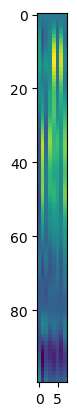

In [71]:
plt.imshow(x['eeg'][0,0:100,:])

In [12]:
predss_1 = predictions
predss_1

array([[0.0201947 , 0.02849911, 0.00893613, 0.07865794, 0.10083618,
        0.7628759 ]], dtype=float32)

# >> Model 2 <<

## Data Generator, Model and utility functions

In [13]:
import librosa
import os, random
import tensorflow
import tensorflow as tf
import albumentations as albu
import pandas as pd, numpy as np
from scipy.signal import butter, lfilter
import tensorflow.keras.backend as K, gc
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Dense, Multiply, Add, Conv1D, Concatenate, LayerNormalization

LOAD_BACKBONE_FROM = '/kaggle/input/efficientnetb-tf-keras/EfficientNetB2.h5'
LOAD_MODELS_FROM = '/kaggle/input/features-head-starter-models'
MODEL = {'K+E+KE': 52}
for DATA_TYPE in MODEL: pass
TARGETS = ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']
FEATS2 = ['Fp1','T3','C3','O1','Fp2','C4','T4','O2']
FEAT2IDX = {x:y for x,y in zip(FEATS2,range(len(FEATS2)))}
FEATS = [['Fp1','F7','T3','T5','O1'],
         ['Fp1','F3','C3','P3','O1'],
         ['Fp2','F8','T4','T6','O2'],
         ['Fp2','F4','C4','P4','O2']]
    
class DataGenerator():
    'Generates data for Keras'
    def __init__(self, data, specs=None, eeg_specs=None, raw_eegs=None , augment=False, mode='train', data_type=DATA_TYPE): 
        self.augment = augment
        self.mode = mode
        self.data_type = data_type
        self.data = self.build_data(data.copy())
        self.specs = specs
        self.eeg_specs = eeg_specs
        self.raw_eegs = raw_eegs
        self.on_epoch_end()
    
    def build_data(self,data):
        if self.data_type in ['K+E']:
            data_dup = pd.concat([data] * 2, ignore_index=True)
            data_dup.loc[:len(data),'data_type'] = 'K'
            data_dup.loc[len(data):,'data_type'] = 'E'
            data = data_dup
        elif self.data_type in ['K+E+KE']:
            data_trp = pd.concat([data] * 3, ignore_index=True)
            data_trp.loc[:len(data),'data_type'] = 'K'
            data_trp.loc[len(data):len(data)*2,'data_type'] = 'E'
            data_trp.loc[len(data)*2:,'data_type'] = 'KE'
            data = data_trp
        else:
            data['data_type'] = self.data_type
        return data
        
    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, index):
        X, y = self.data_generation(index)
        if self.augment: X = self.augmentation(X)
        return X, y
    
    def __call__(self):
        for i in range(self.__len__()):
            yield self.__getitem__(i)
            
            if i == self.__len__()-1:
                self.on_epoch_end()
                
    def on_epoch_end(self):
        if self.mode=='train': 
            self.data = self.data.sample(frac=1).reset_index(drop=True)
    
    def data_generation(self, index):
        row = self.data.iloc[index]
        if row.data_type == 'KE':
            X,y = self.generate_all_specs(index)
        elif row.data_type in ['K','E']:
            X,y = self.generate_specs(index)
        elif row.data_type == 'R':
            X,y = self.generate_raw(index)
        elif row.data_type in ['ER','KR']:
            X1,y = self.generate_specs(index)
            X2,y = self.generate_raw(index)
            X = (X1,X2)
        elif row.data_type in ['KER']:
            X1,y = self.generate_all_specs(index)
            X2,y = self.generate_raw(index)
            X = (X1,X2)
        return X,y
    
    def generate_all_specs(self, index):
        X = np.zeros((512,512,3),dtype='float32')
        y = np.zeros((6,),dtype='float32')
        
        row = self.data.iloc[index]
        if self.mode=='test': 
            offset = 0
        else:
            offset = int(row.offset/2)
        
        eeg = self.eeg_specs[row.eeg_id]
        spec = self.specs[row.spec_id]
        
        imgs = [spec[offset:offset+300,k*100:(k+1)*100].T for k in [0,2,1,3]] # to match kaggle with eeg
        img = np.stack(imgs,axis=-1)
        # LOG TRANSFORM SPECTROGRAM
        img = np.clip(img,np.exp(-4),np.exp(8))
        img = np.log(img)
            
        # STANDARDIZE PER IMAGE
        img = np.nan_to_num(img, nan=0.0)    
            
        mn = img.flatten().min()
        mx = img.flatten().max()
        ep = 1e-5
        img = 255 * (img - mn) / (mx - mn + ep)
        
        X[0_0+56:100+56,:256,0] = img[:,22:-22,0] # LL_k
        X[100+56:200+56,:256,0] = img[:,22:-22,2] # RL_k
        X[0_0+56:100+56,:256,1] = img[:,22:-22,1] # LP_k
        X[100+56:200+56,:256,1] = img[:,22:-22,3] # RP_k
        X[0_0+56:100+56,:256,2] = img[:,22:-22,2] # RL_k
        X[100+56:200+56,:256,2] = img[:,22:-22,1] # LP_k
        
        X[0_0+56:100+56,256:,0] = img[:,22:-22,0] # LL_k
        X[100+56:200+56,256:,0] = img[:,22:-22,2] # RL_k
        X[0_0+56:100+56,256:,1] = img[:,22:-22,1] # LP_k
        X[100+56:200+56,256:,1] = img[:,22:-22,3] # RP_K
        
        # EEG
        img = eeg
        mn = img.flatten().min()
        mx = img.flatten().max()
        ep = 1e-5
        img = 255 * (img - mn) / (mx - mn + ep)
        X[200+56:300+56,:256,0] = img[:,22:-22,0] # LL_e
        X[300+56:400+56,:256,0] = img[:,22:-22,2] # RL_e
        X[200+56:300+56,:256,1] = img[:,22:-22,1] # LP_e
        X[300+56:400+56,:256,1] = img[:,22:-22,3] # RP_e
        X[200+56:300+56,:256,2] = img[:,22:-22,2] # RL_e
        X[300+56:400+56,:256,2] = img[:,22:-22,1] # LP_e
        
        X[200+56:300+56,256:,0] = img[:,22:-22,0] # LL_e
        X[300+56:400+56,256:,0] = img[:,22:-22,2] # RL_e
        X[200+56:300+56,256:,1] = img[:,22:-22,1] # LP_e
        X[300+56:400+56,256:,1] = img[:,22:-22,3] # RP_e

        if self.mode!='test':
            y[:] = row[TARGETS]
        
        return X,y
    
    def generate_specs(self, index):
        X = np.zeros((512,512,3),dtype='float32')
        y = np.zeros((6,),dtype='float32')
        
        row = self.data.iloc[index]
        if self.mode=='test': 
            offset = 0
        else:
            offset = int(row.offset/2)
        
        if row.data_type in ['E','ER']:
            img = self.eeg_specs[row.eeg_id]
        elif row.data_type in ['K','KR']:
            spec = self.specs[row.spec_id]
            imgs = [spec[offset:offset+300,k*100:(k+1)*100].T for k in [0,2,1,3]] # to match kaggle with eeg
            img = np.stack(imgs,axis=-1)
            # LOG TRANSFORM SPECTROGRAM
            img = np.clip(img,np.exp(-4),np.exp(8))
            img = np.log(img)
            
            # STANDARDIZE PER IMAGE
            img = np.nan_to_num(img, nan=0.0)    
            
        mn = img.flatten().min()
        mx = img.flatten().max()
        ep = 1e-5
        img = 255 * (img - mn) / (mx - mn + ep)
        
        X[0_0+56:100+56,:256,0] = img[:,22:-22,0]
        X[100+56:200+56,:256,0] = img[:,22:-22,2]
        X[0_0+56:100+56,:256,1] = img[:,22:-22,1]
        X[100+56:200+56,:256,1] = img[:,22:-22,3]
        X[0_0+56:100+56,:256,2] = img[:,22:-22,2]
        X[100+56:200+56,:256,2] = img[:,22:-22,1]
        
        X[0_0+56:100+56,256:,0] = img[:,22:-22,0]
        X[100+56:200+56,256:,0] = img[:,22:-22,1]
        X[0_0+56:100+56,256:,1] = img[:,22:-22,2]
        X[100+56:200+56,256:,1] = img[:,22:-22,3]
        
        X[200+56:300+56,:256,0] = img[:,22:-22,0]
        X[300+56:400+56,:256,0] = img[:,22:-22,1]
        X[200+56:300+56,:256,1] = img[:,22:-22,2]
        X[300+56:400+56,:256,1] = img[:,22:-22,3]
        X[200+56:300+56,:256,2] = img[:,22:-22,3]
        X[300+56:400+56,:256,2] = img[:,22:-22,2]
        
        X[200+56:300+56,256:,0] = img[:,22:-22,0]
        X[300+56:400+56,256:,0] = img[:,22:-22,2]
        X[200+56:300+56,256:,1] = img[:,22:-22,1]
        X[300+56:400+56,256:,1] = img[:,22:-22,3]
        
        if self.mode!='test':
            y[:] = row[TARGETS]
        
        return X,y
    
    def generate_raw(self,index):
        if USE_PROCESSED and self.mode!='test':
            X = np.zeros((2_000,8),dtype='float32')
            y = np.zeros((6,),dtype='float32')
            row = self.data.iloc[index]
            X = self.raw_eegs[row.eeg_id]
            y[:] = row[TARGETS]
            return X,y
        
        X = np.zeros((10_000,8),dtype='float32')
        y = np.zeros((6,),dtype='float32')
        
        row = self.data.iloc[index]
        eeg = self.raw_eegs[row.eeg_id]
            
        # FEATURE ENGINEER
        X[:,0] = eeg[:,FEAT2IDX['Fp1']] - eeg[:,FEAT2IDX['T3']]
        X[:,1] = eeg[:,FEAT2IDX['T3']] - eeg[:,FEAT2IDX['O1']]
            
        X[:,2] = eeg[:,FEAT2IDX['Fp1']] - eeg[:,FEAT2IDX['C3']]
        X[:,3] = eeg[:,FEAT2IDX['C3']] - eeg[:,FEAT2IDX['O1']]
            
        X[:,4] = eeg[:,FEAT2IDX['Fp2']] - eeg[:,FEAT2IDX['C4']]
        X[:,5] = eeg[:,FEAT2IDX['C4']] - eeg[:,FEAT2IDX['O2']]
            
        X[:,6] = eeg[:,FEAT2IDX['Fp2']] - eeg[:,FEAT2IDX['T4']]
        X[:,7] = eeg[:,FEAT2IDX['T4']] - eeg[:,FEAT2IDX['O2']]
            
        # STANDARDIZE
        X = np.clip(X,-1024,1024)
        X = np.nan_to_num(X, nan=0) / 32.0
            
        # BUTTER LOW-PASS FILTER
        X = self.butter_lowpass_filter(X)
        # Downsample
        X = X[::5,:]
        
        if self.mode!='test':
            y[:] = row[TARGETS]
                
        return X,y
        
    def butter_lowpass_filter(self, data, cutoff_freq=20, sampling_rate=200, order=4):
        nyquist = 0.5 * sampling_rate
        normal_cutoff = cutoff_freq / nyquist
        b, a = butter(order, normal_cutoff, btype='low', analog=False)
        filtered_data = lfilter(b, a, data, axis=0)
        return filtered_data
    
    def resize(self, img,size):
        composition = albu.Compose([
                albu.Resize(size[0],size[1])
            ])
        return composition(image=img)['image']
            
    def augmentation(self, img):
        composition = albu.Compose([
                albu.HorizontalFlip(p=0.4)
            ])
        return composition(image=img)['image']

def spectrogram_from_eeg(parquet_path):
    
    # LOAD MIDDLE 50 SECONDS OF EEG SERIES
    eeg = pd.read_parquet(parquet_path)
    middle = (len(eeg)-10_000)//2
    eeg = eeg.iloc[middle:middle+10_000]
    
    # VARIABLE TO HOLD SPECTROGRAM
    img = np.zeros((100,300,4),dtype='float32')

    for k in range(4):
        COLS = FEATS[k]
        
        for kk in range(4):
            # FILL NANS
            x1 = eeg[COLS[kk]].values
            x2 = eeg[COLS[kk+1]].values
            m = np.nanmean(x1)
            if np.isnan(x1).mean()<1: x1 = np.nan_to_num(x1,nan=m)
            else: x1[:] = 0
            m = np.nanmean(x2)
            if np.isnan(x2).mean()<1: x2 = np.nan_to_num(x2,nan=m)
            else: x2[:] = 0
                
            # COMPUTE PAIR DIFFERENCES
            x = x1 - x2

            # RAW SPECTROGRAM
            mel_spec = librosa.feature.melspectrogram(y=x, sr=200, hop_length=len(x)//300, 
                  n_fft=1024, n_mels=100, fmin=0, fmax=20, win_length=128)
            
            # LOG TRANSFORM
            width = (mel_spec.shape[1]//30)*30
            mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max).astype(np.float32)[:,:width]
            img[:,:,k] += mel_spec_db
                
        # AVERAGE THE 4 MONTAGE DIFFERENCES
        img[:,:,k] /= 4.0
          
    return img

def eeg_from_parquet(parquet_path):

    eeg = pd.read_parquet(parquet_path, columns=FEATS2)
    rows = len(eeg)
    offset = (rows-10_000)//2
    eeg = eeg.iloc[offset:offset+10_000]
    data = np.zeros((10_000,len(FEATS2)))
    for j,col in enumerate(FEATS2):
        
        # FILL NAN
        x = eeg[col].values.astype('float32')
        m = np.nanmean(x)
        if np.isnan(x).mean()<1: x = np.nan_to_num(x,nan=m)
        else: x[:] = 0
        
        data[:,j] = x

    return data

def build_spec_model(hybrid=False):  
    inp = tf.keras.layers.Input((512,512,3))
    base_model = load_model(f'{LOAD_BACKBONE_FROM}')    
    x = base_model(inp)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    if not hybrid:
        x = tf.keras.layers.Dense(6,activation='softmax', dtype='float32')(x)
    model = tf.keras.Model(inputs=inp, outputs=x)
    opt = tf.keras.optimizers.Adam(learning_rate = 1e-3)
    loss = tf.keras.losses.KLDivergence()
    model.compile(loss=loss, optimizer=opt)  
    return model

def dataset(data, mode='train', batch_size=32, data_type=DATA_TYPE, 
            augment=False, specs=None, eeg_specs=None, raw_eegs=None):
    
    gen = DataGenerator(data,mode=mode, data_type=data_type, augment=augment,
                       specs=specs, eeg_specs=eeg_specs, raw_eegs=raw_eegs)
    inp = tf.TensorSpec(shape=(512,512,3), dtype=tf.float32)     
    output_signature = (inp,tf.TensorSpec(shape=(6,), dtype=tf.float32))
    dataset = tf.data.Dataset.from_generator(generator=gen, output_signature=output_signature).batch(
        batch_size)
    return dataset

def predict(models, params, fold, models_path=None):
    preds = []
    if models_path is None: models_path = LOAD_MODELS_FROM
    model = build_spec_model()
    for data_type in models:
        data = params['data']
        ver = models[data_type]
        ds = dataset(data_type=data_type, **params)
        model.load_weights(f'{models_path}/model_{data_type}_{ver}_{fold}.weights.h5')
        pred = model.predict(ds)
        if data_type in ['K+E+KE']:
            pred = (pred[:len(data)] + pred[len(data):len(data)*2] + pred[len(data)*2:])/3
        preds.append(pred)
    pred = np.mean(preds,axis=0)
    del model
    gc.collect()
    return pred

## Load Test Data

In [14]:
# READ ALL SPECTROGRAMS
test = pd.read_csv('/kaggle/input/hms-harmful-brain-activity-classification/test.csv')
PATH2 = '/kaggle/input/hms-harmful-brain-activity-classification/test_spectrograms'
files2 = os.listdir(PATH2)
spectrograms2 = {}
for i,f in enumerate(files2):
    if i%100==0: print(i,', ',end='')
    tmp = pd.read_parquet(f'{PATH2}/{f}')
    name = int(f.split('.')[0])
    spectrograms2[name] = tmp.iloc[:,1:].values
    
# RENAME FOR DATA GENERATOR
test = test.rename({'spectrogram_id':'spec_id'},axis=1)

# READ ALL EEG SPECTROGRAMS
PATH2 = '/kaggle/input/hms-harmful-brain-activity-classification/test_eegs'
EEG_IDS2 = test.eeg_id.unique()
all_eegs2 = {}
for i,eeg_id in enumerate(EEG_IDS2):
        
    # CREATE SPECTROGRAM FROM EEG PARQUET
    img = spectrogram_from_eeg(f'{PATH2}/{eeg_id}.parquet')
    all_eegs2[eeg_id] = img

# READ ALL RAW EEG SIGNALS
all_raw_eegs2 = {}
for i,eeg_id in enumerate(EEG_IDS2):
        
    # SAVE EEG TO PYTHON DICTIONARY OF NUMPY ARRAYS
    data = eeg_from_parquet(f'{PATH2}/{eeg_id}.parquet')
    all_raw_eegs2[eeg_id] = data

0 , 

## Predict

In [15]:
preds = []
params = {'data':test,'mode':'test','specs':spectrograms2, 'eeg_specs':all_eegs2, 'raw_eegs':all_raw_eegs2}

for i in range(5):
    print(f'Fold {i+1}')
    pred = predict(MODEL,params,i)
    preds.append(pred)
    
pred = np.mean(preds,axis=0)

Fold 1
1/1 [==============================] - 5s 5s/step
Fold 2
1/1 [==============================] - 3s 3s/step
Fold 3
1/1 [==============================] - 3s 3s/step
Fold 4
1/1 [==============================] - 3s 3s/step
Fold 5
1/1 [==============================] - 3s 3s/step


In [16]:
predss_2 = pred
predss_2

array([[0.15286334, 0.10176362, 0.00156852, 0.3771529 , 0.00880165,
        0.35785   ]], dtype=float32)

# >>Model 3<<

In [17]:
import gc
import os
import random
import warnings
import numpy as np
import pandas as pd
from IPython.display import display

import timm
import torch
import torch.nn as nn  
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms

from scipy import signal

warnings.filterwarnings('ignore', category=Warning)
gc.collect()

471

In [18]:
class Config:
    seed = 3131
    image_transform = transforms.Resize((512, 512))
    num_folds = 5
    dataset_wide_mean = -0.2972692229201065 #From Train notebook
    dataset_wide_std = 2.5997336315611026 #From Train notebook
    ownspec_mean = 7.29084372799223e-05 # From Train spectrograms notebook
    ownspec_std = 4.510082606216031 # From Train spectrograms notebook
    
def set_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    
set_seed(Config.seed)

In [19]:
test_df = pd.read_csv("/kaggle/input/hms-harmful-brain-activity-classification/test.csv")
submission = pd.read_csv("/kaggle/input/hms-harmful-brain-activity-classification/sample_submission.csv")

submission = submission.merge(test_df, on='eeg_id', how='left')
submission['path_spec'] = submission['spectrogram_id'].apply(lambda x: f"/kaggle/input/hms-harmful-brain-activity-classification/test_spectrograms/{x}.parquet")
submission['path_eeg'] = submission['eeg_id'].apply(lambda x: f"/kaggle/input/hms-harmful-brain-activity-classification/test_eegs/{x}.parquet")

display(submission)

gc.collect()

,eeg_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,spectrogram_id,patient_id,path_spec,path_eeg
0,3911565283,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,853520,6885,/kaggle/input/hms-harmful-brain-activity-class...,/kaggle/input/hms-harmful-brain-activity-class...


0

In [20]:
models = []

# Load in original EfficientnetB0 model
for i in range(Config.num_folds):
    model_effnet_b0 = timm.create_model('efficientnet_b0', pretrained=False, num_classes=6, in_chans=1)
    model_effnet_b0.load_state_dict(torch.load(f'/kaggle/input/hms-train-efficientnetb0/efficientnet_b0_fold{i}.pth', map_location=torch.device('cpu')))
    models.append(model_effnet_b0)
    
models_datawide = []
# Load in hyperparameter optimized EfficientnetB1
for i in range(Config.num_folds):
    model_effnet_b1 = timm.create_model('efficientnet_b1', pretrained=False, num_classes=6, in_chans=1)
    model_effnet_b1.load_state_dict(torch.load(f'/kaggle/input/train/efficientnet_b1_fold{i}.pth', map_location=torch.device('cpu')))
    models_datawide.append(model_effnet_b1)
    
models_ownspec = []
# Load in EfficientnetB1 with new spectrograms
for i in range(Config.num_folds):
    model_effnet_b1 = timm.create_model('efficientnet_b1', pretrained=False, num_classes=6, in_chans=1)
    model_effnet_b1.load_state_dict(torch.load(f'/kaggle/input/efficientnet-b1-ownspectrograms/efficientnet_b1_fold{i}_datawide_CosineAnnealingLR_0.001_False.pth', map_location=torch.device('cpu')))
    models_ownspec.append(model_effnet_b1)
    
gc.collect()

63

In [21]:
test_predictions = []

def create_spectrogram(data):
    """This function will create a spectrogram based on EEG-data"""
    nperseg = 150  # Length of each segment
    noverlap = 128  # Overlap between segments
    NFFT = max(256, 2 ** int(np.ceil(np.log2(nperseg))))

    # LL Spec = ( spec(Fp1 - F7) + spec(F7 - T3) + spec(T3 - T5) + spec(T5 - O1) )/4
    freqs, t,spectrum_LL1 = signal.spectrogram(data['Fp1']-data['F7'],nfft=NFFT,noverlap = noverlap,nperseg=nperseg)
    freqs, t,spectrum_LL2 = signal.spectrogram(data['F7']-data['T3'],nfft=NFFT, noverlap = noverlap,nperseg=nperseg)
    freqs, t,spectrum_LL3 = signal.spectrogram(data['T3']-data['T5'],nfft=NFFT, noverlap = noverlap,nperseg=nperseg)
    freqs, t,spectrum_LL4 = signal.spectrogram(data['T5']-data['O1'],nfft=NFFT, noverlap = noverlap,nperseg=nperseg)

    LL = (spectrum_LL1+ spectrum_LL2 +spectrum_LL3 + spectrum_LL4)/4

    # LP Spec = ( spec(Fp1 - F3) + spec(F3 - C3) + spec(C3 - P3) + spec(P3 - O1) )/4
    freqs, t,spectrum_LP1 = signal.spectrogram(data['Fp1']-data['F3'],nfft=NFFT, noverlap = noverlap,nperseg=nperseg)
    freqs, t,spectrum_LP2 = signal.spectrogram(data['F3']-data['C3'],nfft=NFFT, noverlap = noverlap,nperseg=nperseg)
    freqs, t,spectrum_LP3 = signal.spectrogram(data['C3']-data['P3'],nfft=NFFT, noverlap = noverlap,nperseg=nperseg)
    freqs, t,spectrum_LP4 = signal.spectrogram(data['P3']-data['O1'],nfft=NFFT, noverlap = noverlap,nperseg=nperseg)

    LP = (spectrum_LP1+ spectrum_LP2 +spectrum_LP3 + spectrum_LP4)/4

    # RP Spec = ( spec(Fp2 - F4) + spec(F4 - C4) + spec(C4 - P4) + spec(P4 - O2) )/4
    freqs, t,spectrum_RP1 = signal.spectrogram(data['Fp2']-data['F4'],nfft=NFFT, noverlap = noverlap,nperseg=nperseg)
    freqs, t,spectrum_RP2 = signal.spectrogram(data['F4']-data['C4'],nfft=NFFT, noverlap = noverlap,nperseg=nperseg)
    freqs, t,spectrum_RP3 = signal.spectrogram(data['C4']-data['P4'],nfft=NFFT, noverlap = noverlap,nperseg=nperseg)
    freqs, t,spectrum_RP4 = signal.spectrogram(data['P4']-data['O2'],nfft=NFFT, noverlap = noverlap,nperseg=nperseg)

    RP = (spectrum_RP1+ spectrum_RP2 +spectrum_RP3 + spectrum_RP4)/4


    # RL Spec = ( spec(Fp2 - F8) + spec(F8 - T4) + spec(T4 - T6) + spec(T6 - O2) )/4
    freqs, t,spectrum_RL1 = signal.spectrogram(data['Fp2']-data['F8'],nfft=NFFT, noverlap = noverlap,nperseg=nperseg)
    freqs, t,spectrum_RL2 = signal.spectrogram(data['F8']-data['T4'],nfft=NFFT, noverlap = noverlap,nperseg=nperseg)
    freqs, t,spectrum_RL3 = signal.spectrogram(data['T4']-data['T6'],nfft=NFFT, noverlap = noverlap,nperseg=nperseg)
    freqs, t,spectrum_RL4 = signal.spectrogram(data['T6']-data['O2'],nfft=NFFT, noverlap = noverlap,nperseg=nperseg)
    RL = (spectrum_RL1+ spectrum_RL2 +spectrum_RL3 + spectrum_RL4)/4
    spectogram = np.concatenate((LL, LP,RP,RL), axis=0)
    return spectogram

def preprocess_ownspec(path_to_parquet):
    """The data will be processed from EEG to spectrogramdata"""
    data = pd.read_parquet(path_to_parquet)
    data = create_spectrogram(data)
    mask = np.isnan(data)
    data[mask] = -1
    data = np.clip(data, np.exp(-6), np.exp(10))
    data = np.log(data)
    
    return data 

def preprocess(path_to_parquet):
    data = pd.read_parquet(path_to_parquet)
    data = data.fillna(-1).values[:, 1:].T
    data = np.clip(data, np.exp(-6), np.exp(10))
    data = np.log(data)
    
    return data


def normalize_datawide(data_point):
    """The spectrogram data will be normalized data wide."""
    eps = 1e-6

    data_point = (data_point - Config.dataset_wide_mean) / (Config.dataset_wide_std + eps)

    data_tensor = torch.unsqueeze(torch.Tensor(data_point), dim=0)
    data_point = Config.image_transform(data_tensor)

    return data_point


def normalize_datawide_ownspec(data):
    """The new spectrogram data will be normalized data wide."""
    eps = 1e-6
    
    data = (data - Config.ownspec_mean) / (Config.ownspec_std + eps)
    data_tensor = torch.unsqueeze(torch.Tensor(data), dim=0)
    data = Config.image_transform(data_tensor)
    
    return data


def normalize_instance_wise(data_point):
    """The spectrogram data will be normalized instance wise."""
    eps = 1e-6
    
    data_mean = data_point.mean(axis=(0, 1))
    data_std = data_point.std(axis=(0, 1))
    data_point = (data_point - data_mean) / (data_std + eps)
    
    data_tensor = torch.unsqueeze(torch.Tensor(data_point), dim=0)
    data_point = Config.image_transform(data_tensor)
    
    return data_point

# Loop over samples
for index in submission.index:
    test_predictions_per_model = []
    
    preprocessed_data = preprocess(submission.iloc[index]['path_spec'])
    preprocessed_data_ownspec = preprocess_ownspec(submission.iloc[index]['path_eeg'])
    
    # Predict based on original EfficientnetB0 models. 
    for i in range(len(models)):
        models[i].eval()
        
        current_parquet_data = normalize_instance_wise(preprocessed_data).unsqueeze(0)
        
        with torch.no_grad():
            model_output = models[i](current_parquet_data)
            current_model_prediction = F.softmax(model_output)[0].detach().cpu().numpy()
            
        test_predictions_per_model.append(current_model_prediction)
    
    # Predict based on hyperparameter optimized EffcientnetB1.
    for i in range(len(models_datawide)):
        models_datawide[i].eval()
        
        current_parquet_data = normalize_datawide(preprocessed_data).unsqueeze(0)
        
        with torch.no_grad():
            model_output = models_datawide[i](current_parquet_data)
            current_model_prediction = F.softmax(model_output)[0].detach().cpu().numpy()
            
        test_predictions_per_model.append(current_model_prediction)
    
    # Predict based on EfficientnetB1 model with new spectrograms.
    for i in range(len(models_ownspec)):
        models_ownspec[i].eval()
        
        current_parquet_data = normalize_datawide_ownspec(preprocessed_data_ownspec).unsqueeze(0)
        
        with torch.no_grad():
            model_output = models_ownspec[i](current_parquet_data)
            current_model_prediction = F.softmax(model_output)[0].detach().cpu().numpy()
            
        test_predictions_per_model.append(current_model_prediction)
    
    # The mean of all models is taken.
    ensemble_prediction = np.mean(test_predictions_per_model,axis=0)
    
    test_predictions.append(ensemble_prediction)

test_predictions = np.array(test_predictions)

gc.collect()

0

In [22]:
predss_3 = test_predictions
predss_3

array([[0.03419812, 0.07484972, 0.001024  , 0.38697532, 0.01671714,
        0.48623565]], dtype=float32)

# Submission Model 1 + Model 2 + Model 3

In [23]:
submission=pd.read_csv("/kaggle/input/hms-harmful-brain-activity-classification/sample_submission.csv")
labels=['seizure','lpd','gpd','lrda','grda','other']
for i in range(len(labels)):
    submission[f'{labels[i]}_vote']=(predss_1[:,i] * 0.2 + predss_2[:, i] * 0.4 + predss_3[:, i] * 0.4)
submission.to_csv("submission.csv",index=None)
display(submission.head())

,eeg_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,3911565283,0.078864,0.076345,0.002824,0.321383,0.030375,0.490209


In [24]:
# SANITY CHECK TO CONFIRM PREDICTIONS SUM TO ONE
submission.iloc[:,-6:].sum(axis=1)

0    1.0
dtype: float32